## Segmentação de Imagens de áreas desmatadas obtidas pelo Satélite Landsat8

In [573]:
#Importando bibliotecas
import pkg_resources
import numpy as np
from matplotlib import pyplot as plt
from skimage import filters, morphology 
from multiearth_challenge.datasets import segmentation_dataset as sd
from tqdm import tqdm


In [574]:

# Define os caminhos para os arquivos de dados de amostra
# Estes são os arquivos de entrada (imagem de satélite) e alvo (máscara de segmentação).
source_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/landsat8_sample.nc")]
segmentation_files = [pkg_resources.resource_filename("multiearth_challenge", "data/sample_dataset/deforestation_sample.nc")]

#Bandas que serão utlizadas, neste caso RGB
#Landsat-8, bandas RGB: Vermelho (SR_B4), Verde (SR_B3) e Azul (SR_B2).
source_bands = {"Landsat-8": ['SR_B4', 'SR_B3', 'SR_B2']}

#Configuração do Dataset com as imagens RGB
# O parâmetro mais importante `merge_source_bands=True`, que combina
# as 3 bandas (R, G, B) em uma única imagem de 3 canais.
dataset = sd.ImageSegmentationDataset(
    source_files=source_files,
    segmentation_files=segmentation_files,
    source_bands=source_bands,
    merge_source_bands=True, # ESSENCIAL: Junta as bandas em uma imagem RGB
    source_cloud_coverage=(0.0, 0.0), # Pega apenas imagens sem nuvens
    source_date_window=(-7, 7),
    single_source_image=True,
    error_on_empty=True,
)

print(f"Número de pares (imagem RGB / máscara) encontrados: {len(dataset)}")


Número de pares (imagem RGB / máscara) encontrados: 3


In [575]:

def luminance(image):
    l = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    return l

# Função auxiliar para normalizar a imagem para visualização (valores entre 0 e 1)
def normalize(img):
    img = img.astype(np.float64)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        img = (img - min_val) / (max_val - min_val)
    else:
        img = img * 0  # imagem preta se max==min
    return img


In [576]:

#Criando o vetor de imagens
vetor_img = []
#imagens cinza
imgs_cinza = []

#vetor para as mask
vetor_mask = []
#processa todas as imagens do dataset
for source_data, target_data in tqdm(dataset, desc="Vetorizando Imagens"):
    rgb_image = source_data[0]["image"]  # (3, H, W)
    mask = target_data["image"]
    img_transp = rgb_image.transpose((1,2,0)) # converte para (H, W, 3)
    
    #normalizo a imagem com valores entre 0-1
    rgb_norm = normalize(img_transp)
    
    #vetor com imagens rgb 
    vetor_img.append(rgb_norm)

    #imagens cinzas
    img_g = luminance(img_transp) #aplico a luminacia em img transporta e normalizada
    imgs_cinza.append(normalize(img_g))

    #acumulando as mascaras
    vetor_mask.append(mask.transpose((1,2,0)))


Vetorizando Imagens: 100%|██████████| 3/3 [00:00<00:00, 111.19it/s]


In [577]:
def converter_uint8(img_float):
    #Converte uma imagem float [0, 1] para uint8 (0-255)
    return (img_float * 255).astype(np.uint8)

#Converte a lista de imagens RGB
imagens_rgb = [converter_uint8(img) for img in vetor_img]

#Converte a lista de imagens em tons de cinza
imagens_cinza = [converter_uint8(img) for img in imgs_cinza]



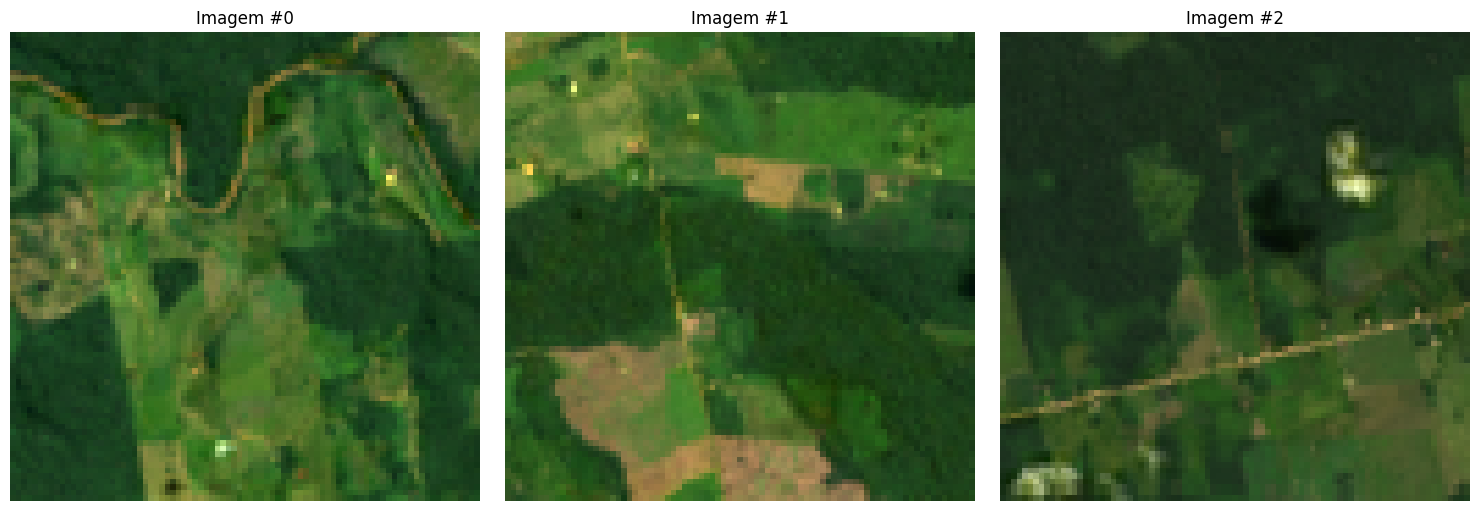

In [578]:
num_a_visualizar = min(3, len(imagens_rgb)) 
fig, axes = plt.subplots(1, num_a_visualizar, figsize=(5 *  num_a_visualizar, 5))
# Garante que 'axes' seja sempre uma lista, mesmo com num_a_visualizar=1
if num_a_visualizar == 1:
    axes = [axes]

for i in range(num_a_visualizar):
     # Transpõe para (H, W, 3) e normaliza para o intervalo [0,1] caso necessário
        img = imagens_rgb[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Imagem #{i}")
        axes[i].axis("off")
    
plt.tight_layout()
plt.show()

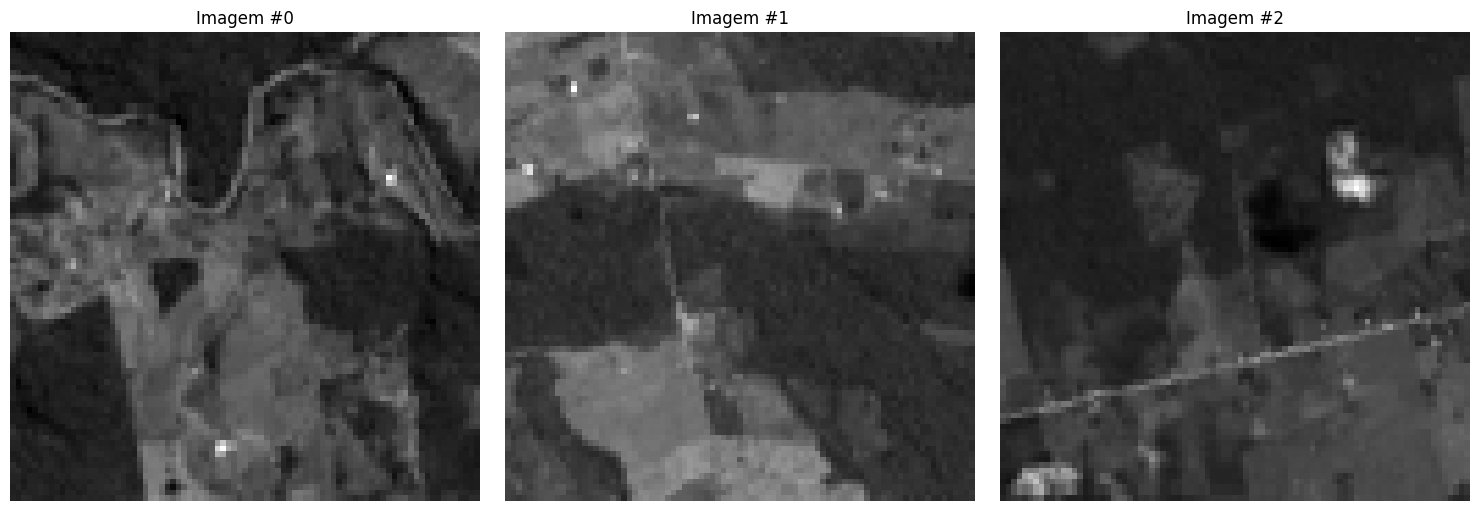

In [579]:
num_a_visualizar = min(3, len(imagens_cinza)) 
fig, axes = plt.subplots(1, num_a_visualizar, figsize=(5 *  num_a_visualizar, 5))
# Garante que 'axes' seja sempre uma lista, mesmo com num_a_visualizar=1
if num_a_visualizar == 1:
    axes = [axes]

for i in range(num_a_visualizar):
     # Transpõe para (H, W, 3) e normaliza para o intervalo [0,1] caso necessário
        img = imagens_cinza[i]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Imagem #{i}")
        axes[i].axis("off")
    
plt.tight_layout()
plt.show()

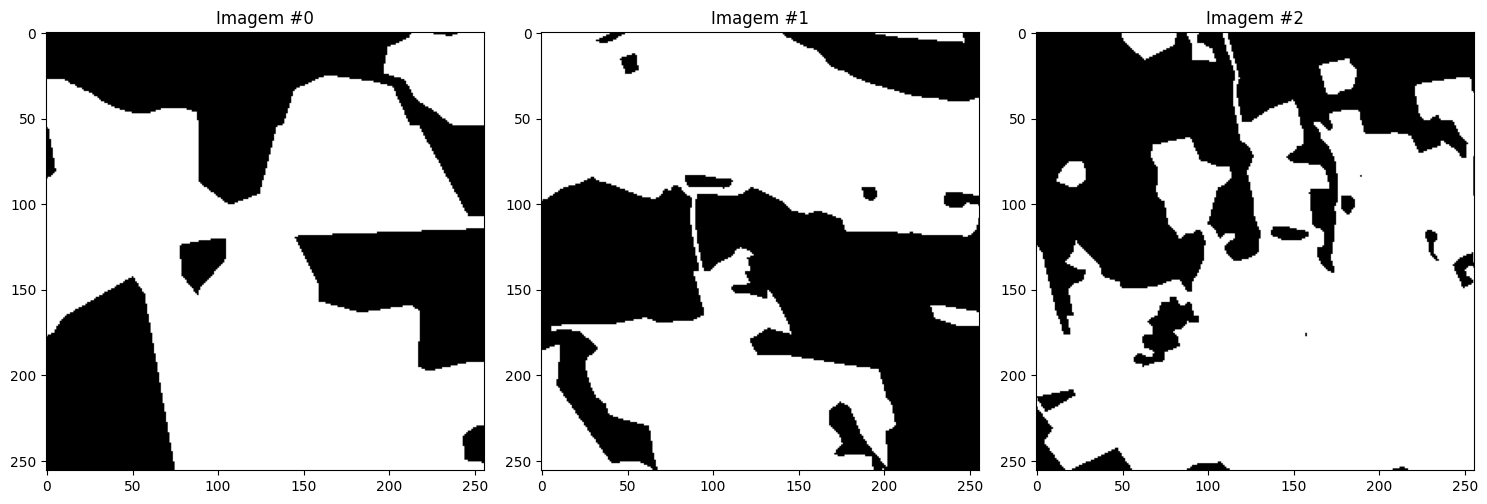

In [580]:
tam = min(3, len(vetor_mask)) 
fig, axes = plt.subplots(1, tam, figsize=(5 *  tam, 5))
# Garante que 'axes' seja sempre uma lista, mesmo com tam=1
if tam == 1:
    axes = [axes]

for i in range(tam):
    img = vetor_mask[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Imagem #{i}")
    axes[i].axis()
    
plt.tight_layout()
plt.show()

#### Aplicação de filtros nas imagens

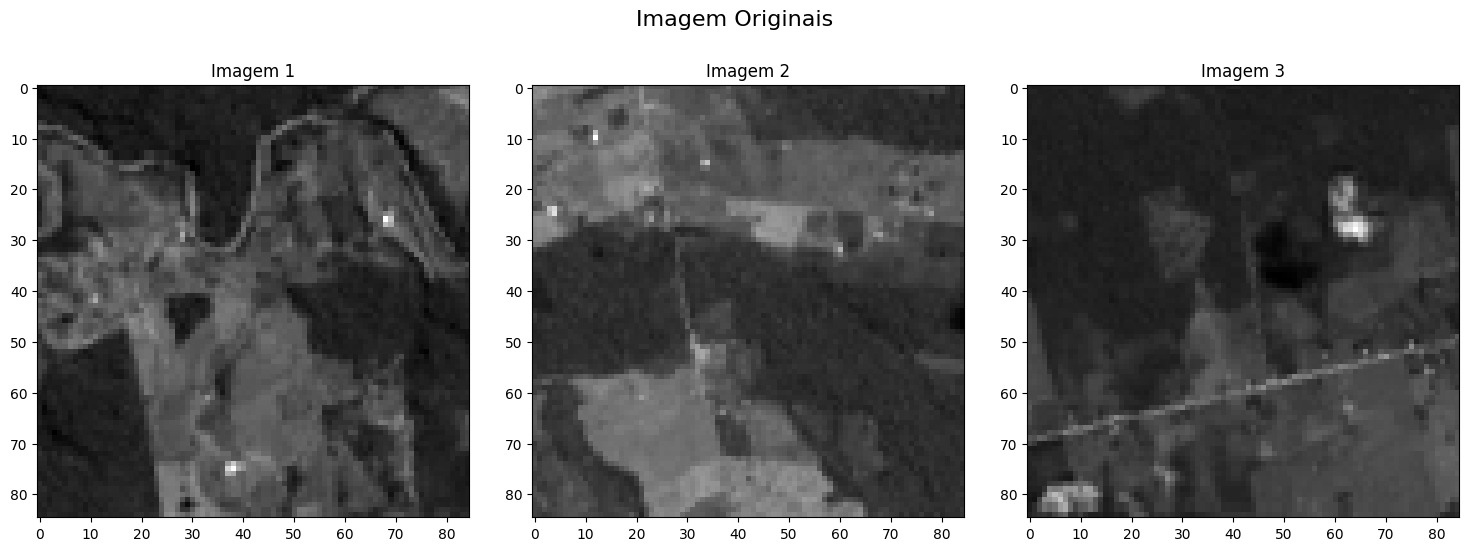

In [581]:
plot_imagens(imagens_cinza, ['Imagem 1', 'Imagem 2','Imagem 3'], "Imagem Originais")

In [582]:
##FUNCÕES DE REALCE 
#Histograma
#Computa a distribuição de intensidades de pixel em uma img
def histograma(img, tam):
    acumulador = np.zeros((tam,))
    h, w = img.shape
    for i in range(h):
        for j in range(w):
            acumulador[img[i, j]] += 1
    return acumulador

#Histograma Cumulativo
#Computa a proporcao de intensidades
def histo_cumulativo(h, L):
    acumulador = np.zeros((L,))
    acumulador[0] = h[0]
    for i in range(1, L):
        acumulador[i] = acumulador[i - 1] + h[i]
    return acumulador

#Funcao que aplica uma equalizacao no histograma
#T(z) = ((L-1)/ total_pixels) * Hc(z)
def transf(hc, img, total=None):
    
    h, w = img.shape
    L = 256  # níveis de cinza
    if total is None:
        total = float(h * w)
    new_img = np.zeros_like(img, dtype=np.uint8)
    aux = (L-1)/total
    for i in range(h):
        for j in range(w):
            z = img[i, j]
            new_val = aux * hc[z]
            new_img[i, j] = new_val
    
    return new_img.astype(np.uint8)

#Realiza a equalizacao de forma individual
def equaliza_indiv(imagens):
    img_eq =  []
    for img in imagens:
        h = histograma(img, 256)
        hc = histo_cumulativo(h, 256)
        img_eq.append(transf(hc, img))
        
    return img_eq

#realiza a equalizacao de forma conjunta, i.e, para n imagens
def equaliza_conj(imagens):
    h_conjunto = np.zeros(256)
    for img in imagens:
        h_conjunto += histograma(img, 256)
    
    hc_conjunto = histo_cumulativo(h_conjunto, 256)
    total_pixels = sum(img.size for img in imagens)  # total de pixels do conjunto
    imagens_eq = [transf(hc_conjunto, img, total=total_pixels) for img in imagens]
    
    return imagens_eq, hc_conjunto

In [583]:
#Funções para plotars imagens lado a lado (2 e 3 ) e histogramas
def plot_2img(tg,img1,title1, img2, title2):
    plt.figure(figsize=(10,5))
    plt.suptitle(tg)

    # 1. Imagem original
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    # 2. Imagem binarizada
    plt.subplot(1,2,2)
    plt.title(title2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
        
def plot_3img(tg, img1, t1, img2, t2, img3, t3):

    # Mostra lado a lado
    plt.figure(figsize=(15, 5))
    plt.suptitle(tg)

    plt.subplot(1, 3, 1)
    plt.title(t1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(t2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(t3)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()   

def plot_imagens(imagens, titulos=None, titulo_geral=None, cmap='gray'):
    tam = len(imagens)
    if titulos is None:
        titulos = [''] * 4  # títulos vazios por padrão

    plt.figure(figsize=(5* tam, 5))

    if titulo_geral:
        plt.suptitle(titulo_geral, fontsize=16, y=1.05)

    for i in range(tam):
        plt.subplot(1, tam, i + 1)
        plt.imshow(imagens[i], cmap=cmap)
        plt.title(titulos[i])
        plt.axis()

    plt.tight_layout()
    plt.show()

def plot_histograms(images, titles, main_title):
    plt.figure(figsize=(15, 10))
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, len(images), i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
        
        plt.subplot(2, len(images), i+1+len(images))
        hist = histograma(img, 256)
        plt.bar(range(256), hist)
        plt.title(f'Histograma {title}')
    
    plt.suptitle(main_title)
    plt.tight_layout()
    plt.show()


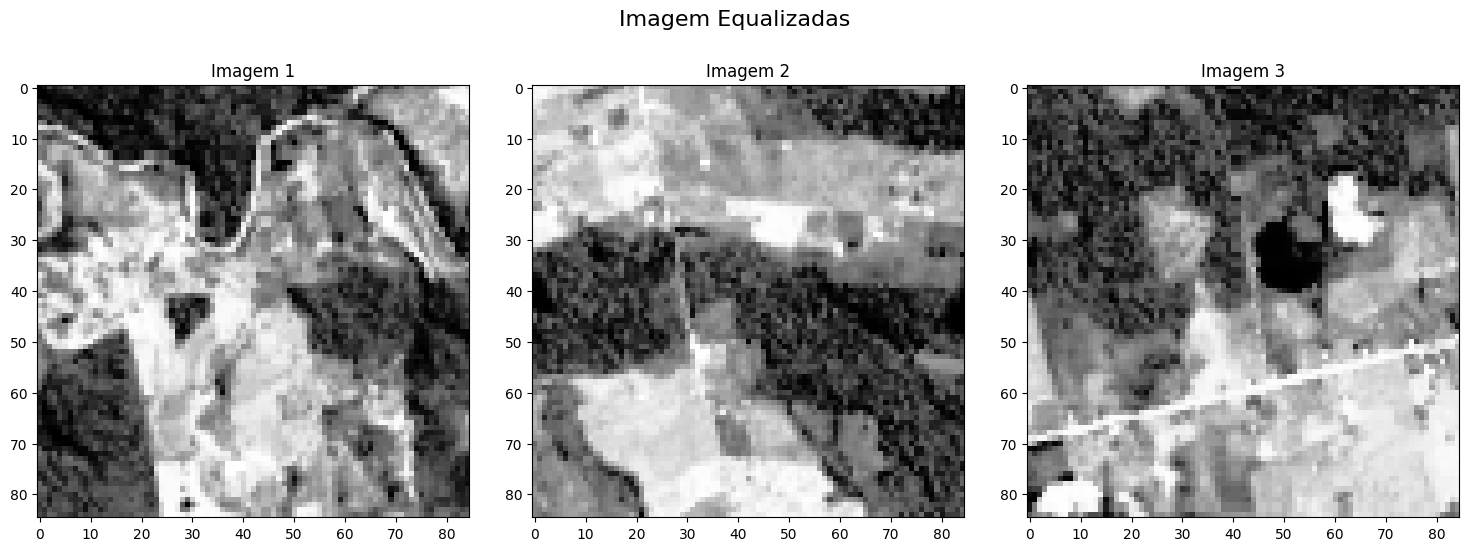

In [584]:
imgs_eq = []
imgs_eq = equaliza_indiv(imagens_cinza)
plot_imagens(imgs_eq, ['Imagem 1', 'Imagem 2','Imagem 3'], "Imagem Equalizadas")

Aplicando o filtro de Minimos QUadrados Restritivos


In [585]:
#Filtro de ruído 
def gaussian_filter(k=3, sigma=1.0):
    arx = np.arange((-k//2) + 1.0, (k//2) + 1.0)
    x,y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))

    return np.array(filt/np.sum(filt))

#Filtro Laplaciano
def operador_laplaciano():
    return np.array([[0,-1,  0],
                     [-1, 4, -1],
                     [0, -1, 0]])

def pad_to_shape(arr, shape):
    """Faz padding de arr para o shape fornecido (centrado)"""
    pad_y = shape[0] - arr.shape[0]
    pad_x = shape[1] - arr.shape[1]
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left
    return np.pad(arr, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

#Filtro de Minimos Quadrados Restritos
def filter_min_quad_rest(sigma, tam_f, img_deg, gama):
    #criando os filtros de degradação(gaussiano) e limitante(laplace)
    laplace = operador_laplaciano()
    filt_deg = gaussian_filter(k = tam_f, sigma=sigma) 
    
    #realizando o padding nos filtros
    filt_h_pad = pad_to_shape(filt_deg, img_deg.shape)
    laplace_pad = pad_to_shape(laplace, img_deg.shape)

    
    #aplicando a tf na imagem e filtros
    img_deg_ft = np.fft.fft2(img_deg)
    filt_h = np.fft.fft2(filt_h_pad)
    filt_h_conj = np.conjugate(filt_h)
    op_laplace = np.fft.fft2(laplace_pad)

    #realizando a filtragem do dominio da frequencia ( produto na frequencia)
    result = (filt_h_conj / (np.abs(filt_h) ** 2 + gama *( np.abs(op_laplace) ** 2))) * img_deg_ft

    #aplicando a tf inversa e voltando pro dominio real
    img_result = np.fft.ifft2(result)
    img_result = np.fft.ifftshift(img_result)
    img_result = np.real(img_result)

    return img_result


In [586]:
gama = 2.0
tam_f = 5
sigm = 0.05
imgs_fmqr = [ ]
for img in imagens_cinza:
    img_filt = filter_min_quad_rest(sigm, tam_f, img, gama)
    imgs_fmqr.append(img_filt)

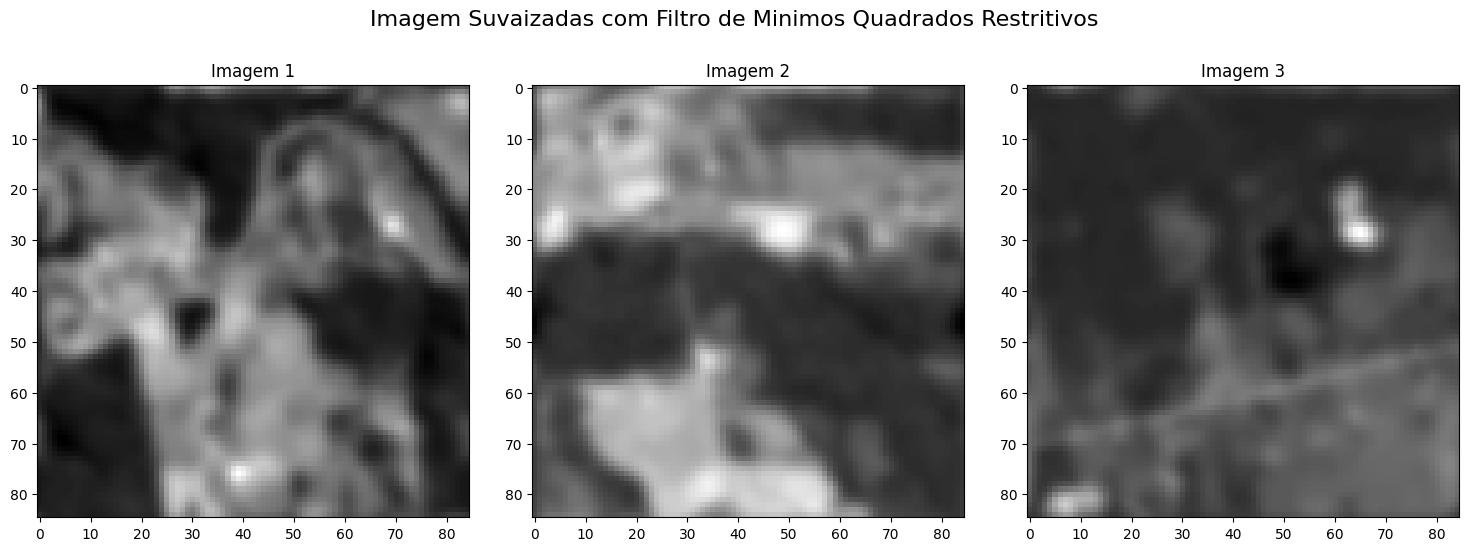

In [587]:

plot_imagens(imgs_fmqr, ['Imagem 1', 'Imagem 2','Imagem 3'], "Imagem Suvaizadas com Filtro de Minimos Quadrados Restritivos")

#### Correções Gamma

Será aplicados em:
* Imagens Originais
* Imagens equalizadas
* Imagens filtradas com Minimos Quadrados restritivos

In [588]:
#Define a equação do realce gama
def realce_gama(img, gama):
    img_gama = img**(1/gama)
    img_gama = normalize(img_gama)
    img_norm = (img_gama * 255).astype(np.uint8)
    return img_norm
#Aplica a correção gama na imagem
def correc_gamma(imagem, gama):
    imagens_gama = realce_gama(imagem, gama)
    return imagens_gama

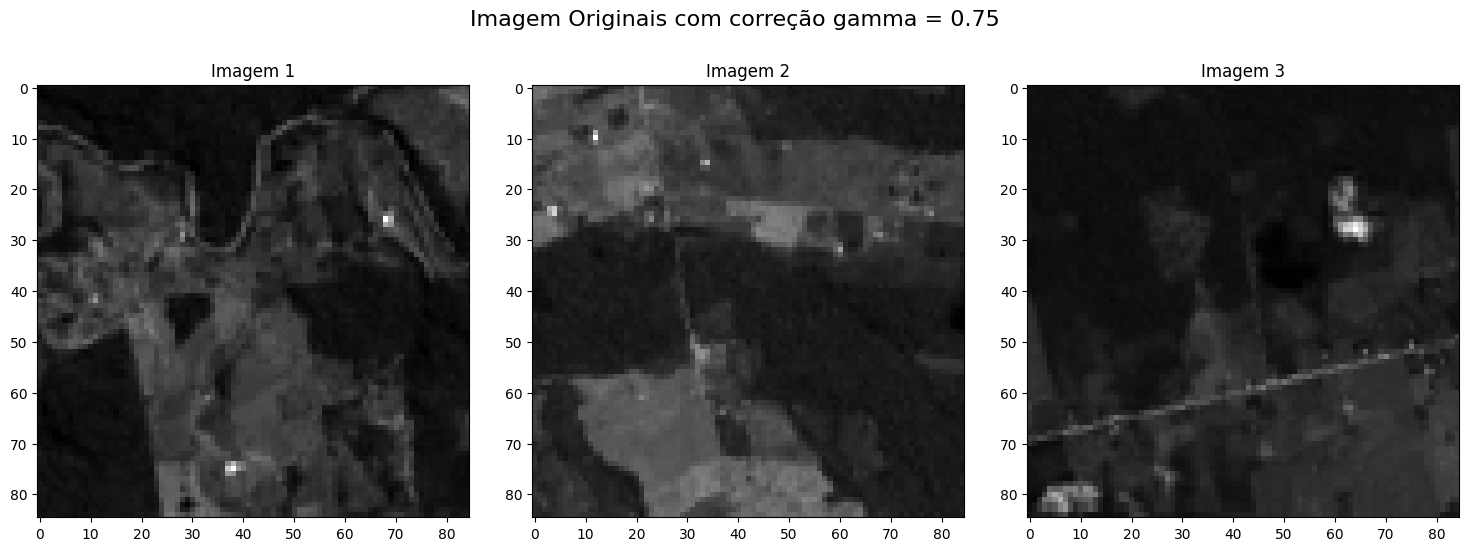

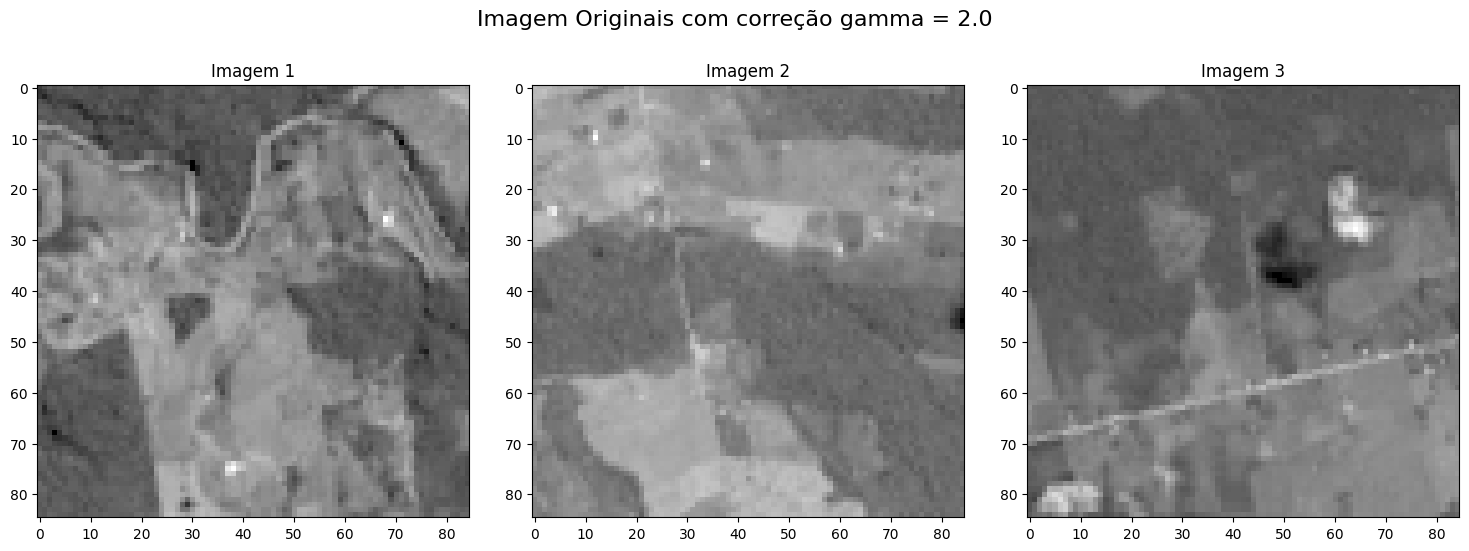

In [589]:
gama1 = 0.75
gama2 = 2.0
io_gama1 = [correc_gamma(img,gama1) for img in imagens_cinza]
io_gama2 = [correc_gamma(img,gama2) for img in imagens_cinza]

plot_imagens(io_gama1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Originais com correção gamma = {gama1}")
plot_imagens(io_gama2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Originais com correção gamma = {gama2}")

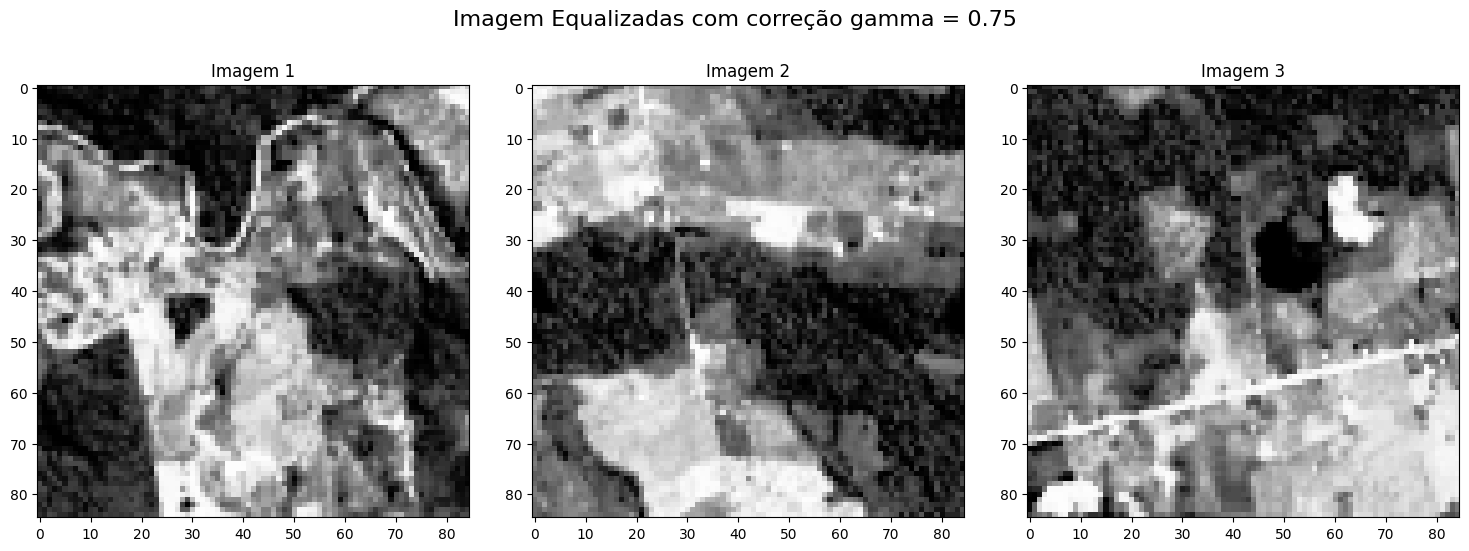

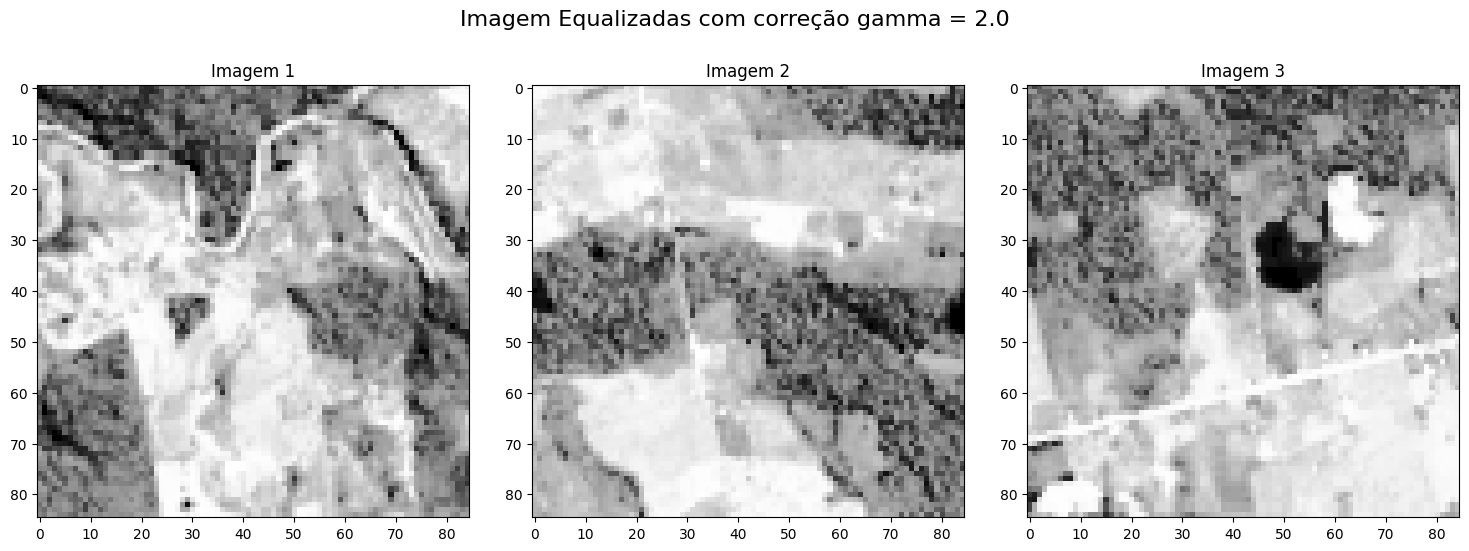

In [590]:
gama1 = 0.75
gama2 = 2.0
ieq_gama1 = [correc_gamma(img,gama1) for img in imgs_eq]
ieq_gama2 = [correc_gamma(img,gama2) for img in imgs_eq]

plot_imagens(ieq_gama1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Equalizadas com correção gamma = {gama1}")
plot_imagens(ieq_gama2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem Equalizadas com correção gamma = {gama2}")

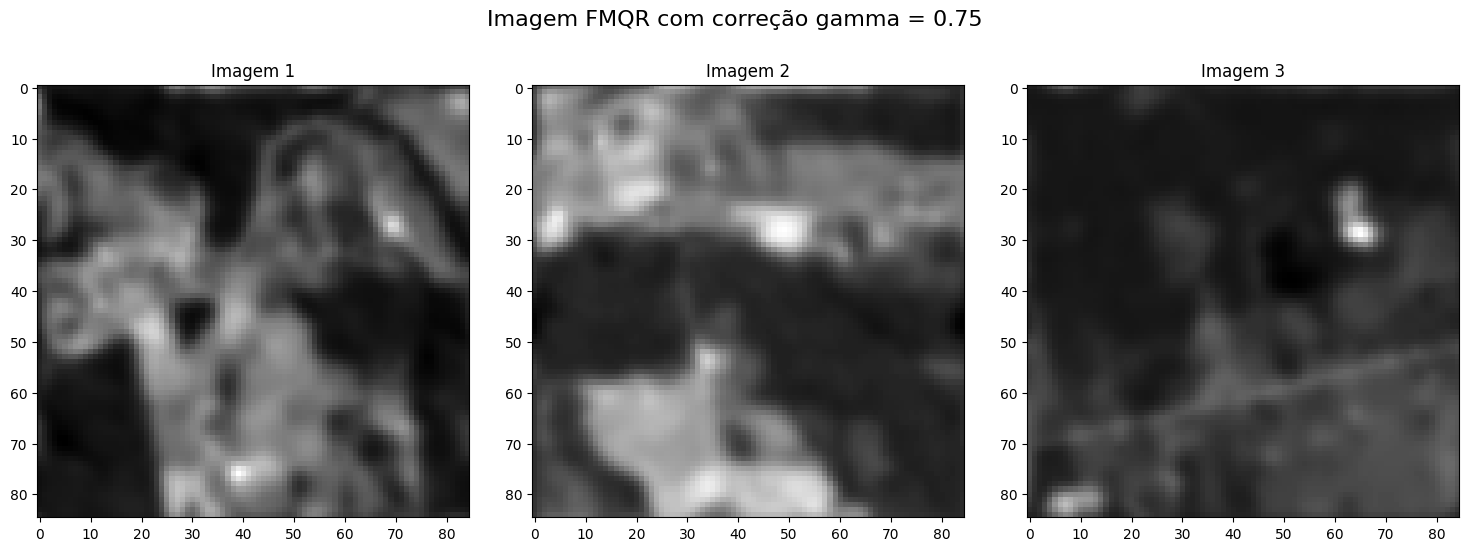

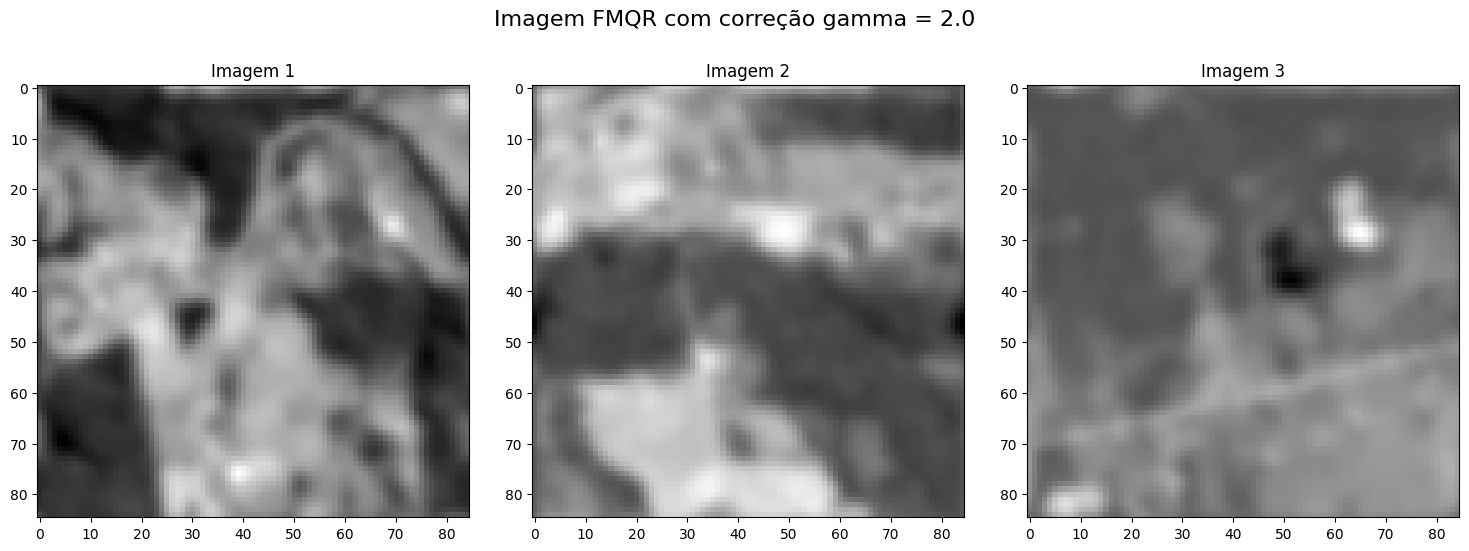

In [591]:
gama1 = 0.75
gama2 = 2.0
ifilt_gama1 = [correc_gamma(img,gama1) for img in imgs_fmqr]
ifilt_gama2 = [correc_gamma(img,gama2) for img in imgs_fmqr]

plot_imagens(ifilt_gama1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem FMQR com correção gamma = {gama1}")
plot_imagens(ifilt_gama2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Imagem FMQR com correção gamma = {gama2}")

In [592]:
def metodo_otsu(imagem):
    #calculando o histograma da imagem
    histo, bin_edges = np.histogram(imagem, bins=np.arange(257))

    #calculando o tamanho da imagem
    total_pixels = imagem.size
    current_max, limiar = 0,0

    #calculando a media global da imagem
    media_global = np.sum(histo * np.arange(256))/total_pixels

    #variaveis auxiliares
    peso_fundo, media_fundo = 0, 0
    soma_fundo = 0

    for i in range(256):
        #peso de fundo
        peso_fundo += histo[i]

        if peso_fundo == 0:
            continue

        #veirificando o primeiro plano
        peso_plan1 =  total_pixels - peso_fundo

        if peso_plan1 == 0:
            break

        #media do fundo
        soma_fundo += i * histo[i]
        media_fundo = soma_fundo / peso_fundo

        #media primeiro plano
        media_plan1 =(media_global * total_pixels - soma_fundo)/peso_plan1

        #calculando a variancia intra_classe
        var_interclas = peso_fundo * peso_plan1 * (media_fundo - media_plan1) ** 2

        #maxima var e limiarização
        if var_interclas > current_max:
            current_max = var_interclas
            limiar = i
        
    return limiar
    

In [593]:
def aplicar_otsu(list_img):
    # Recebe uma lista de imagens e retorna uma outra lista com imagens binarias
    imagens_bin = []
    # Usando tqdm para visualizar o progresso
    for img in tqdm(list_img, desc="Aplicando Otsu"):
        # Calcula o limiar para a imagem atual
        limiar = metodo_otsu(img)
        # Binariza a imagem com base no limiar e adiciona à lista
        bin_img = (img > limiar).astype(np.uint8) * 255
        imagens_bin.append(bin_img)
    return imagens_bin

##### Imagem Original com Correção Gama

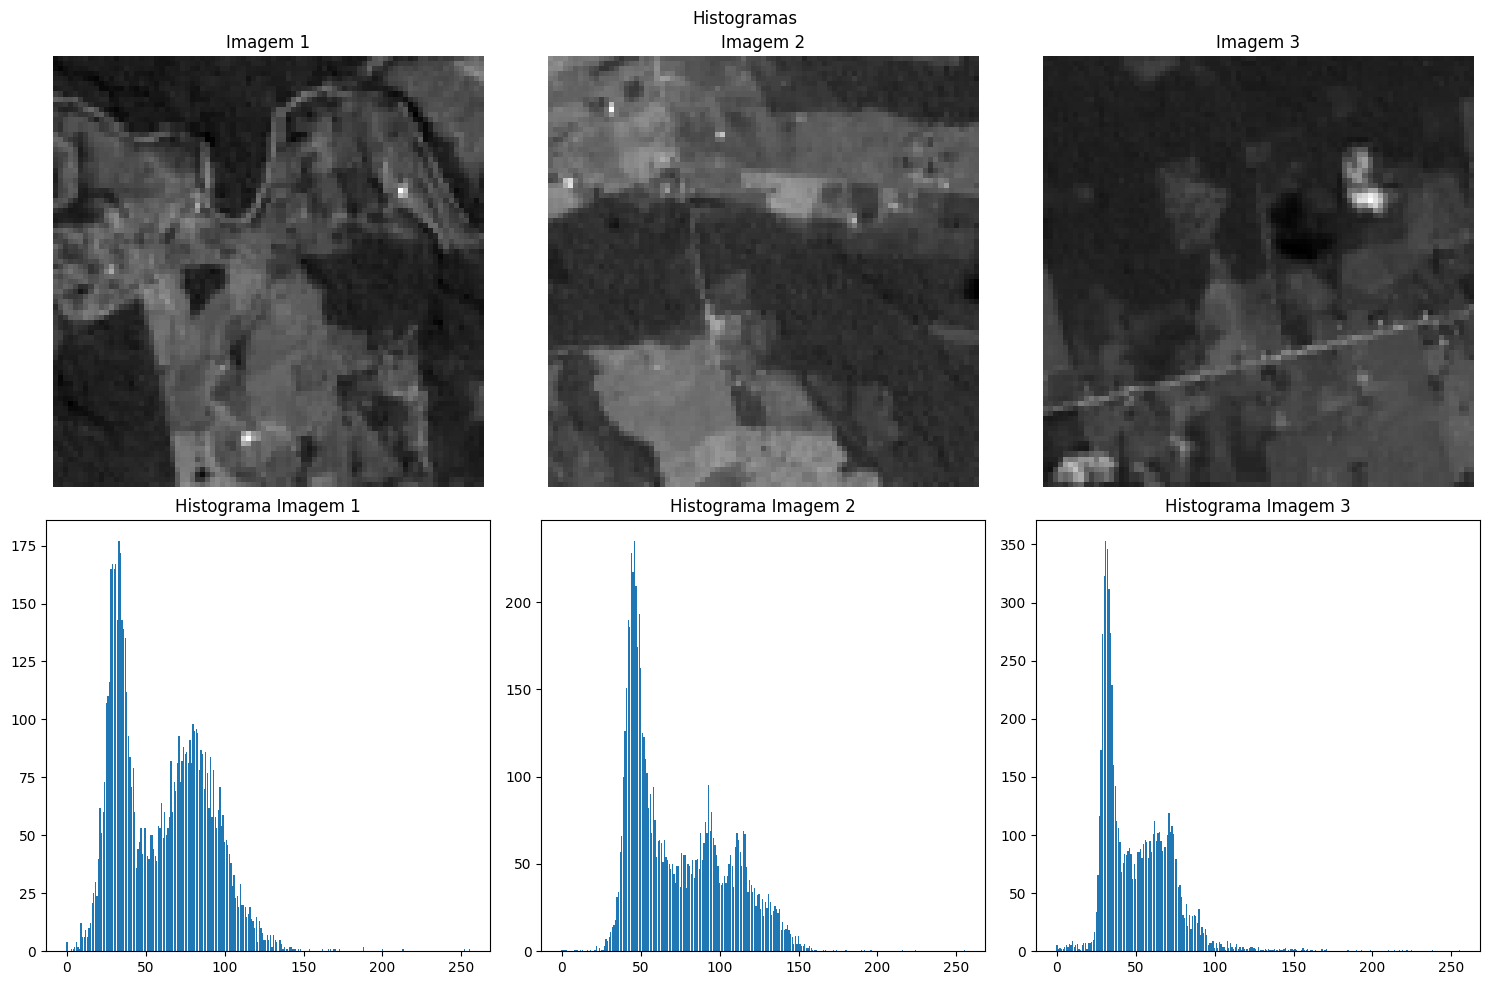

In [594]:
plot_histograms(imagens_cinza, ['Imagem 1', 'Imagem 2','Imagem 3'] , 'Histogramas')

Aplicando Otsu: 100%|██████████| 3/3 [00:00<00:00, 745.83it/s]


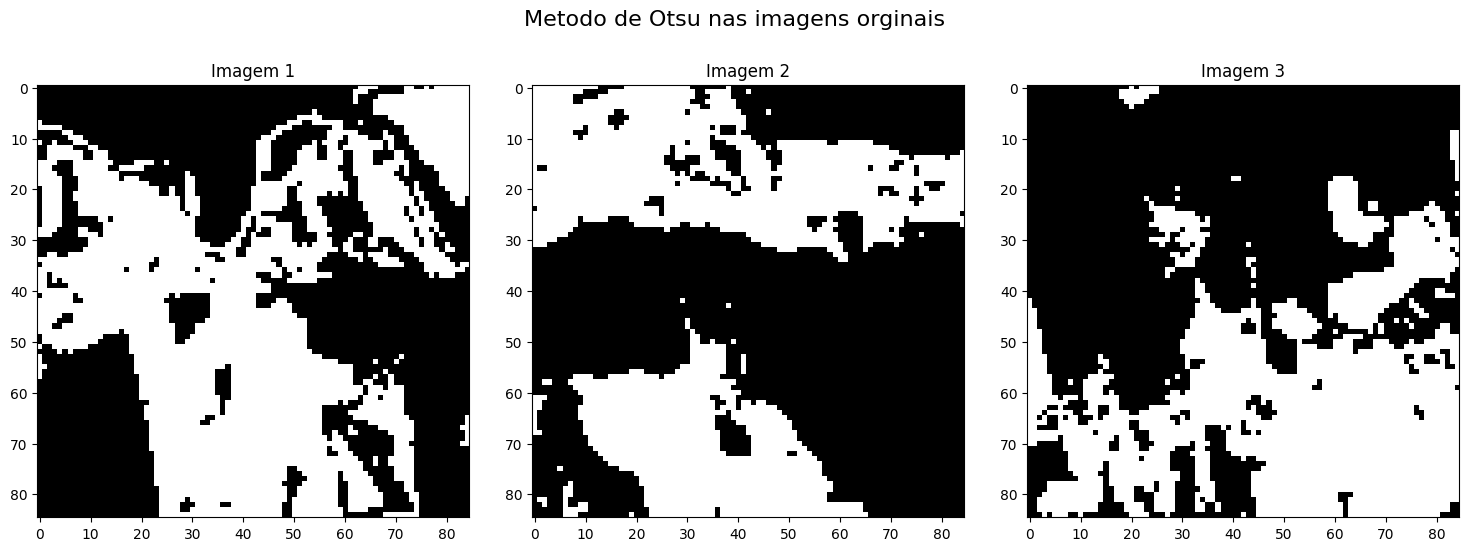

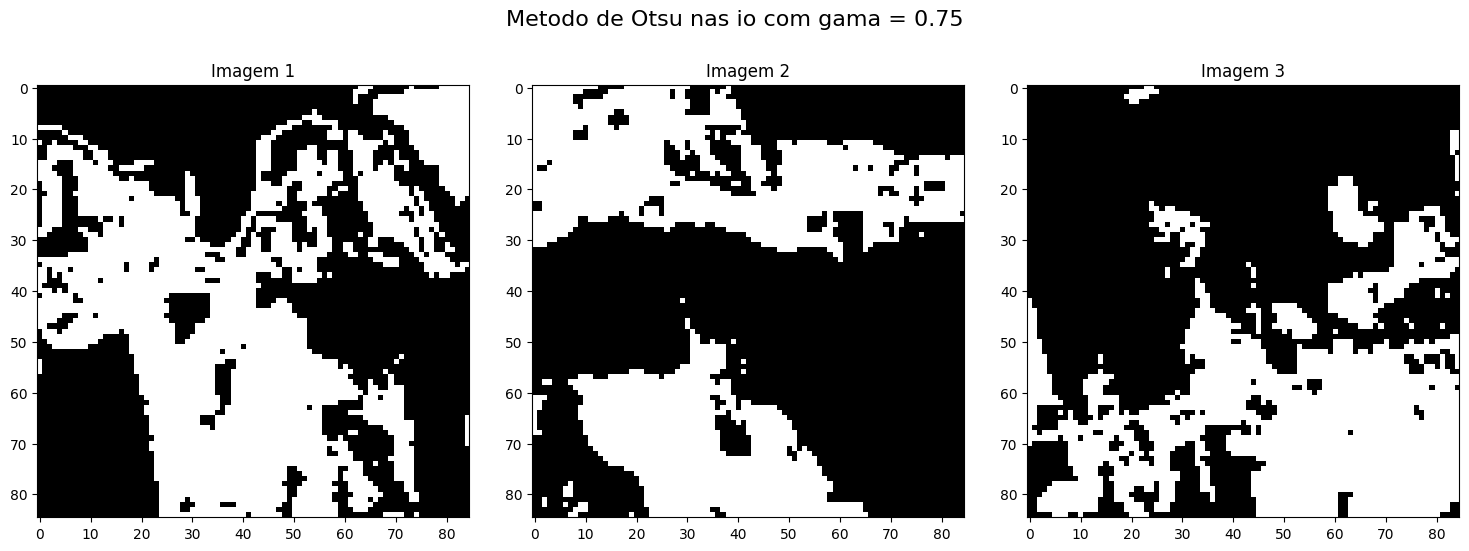

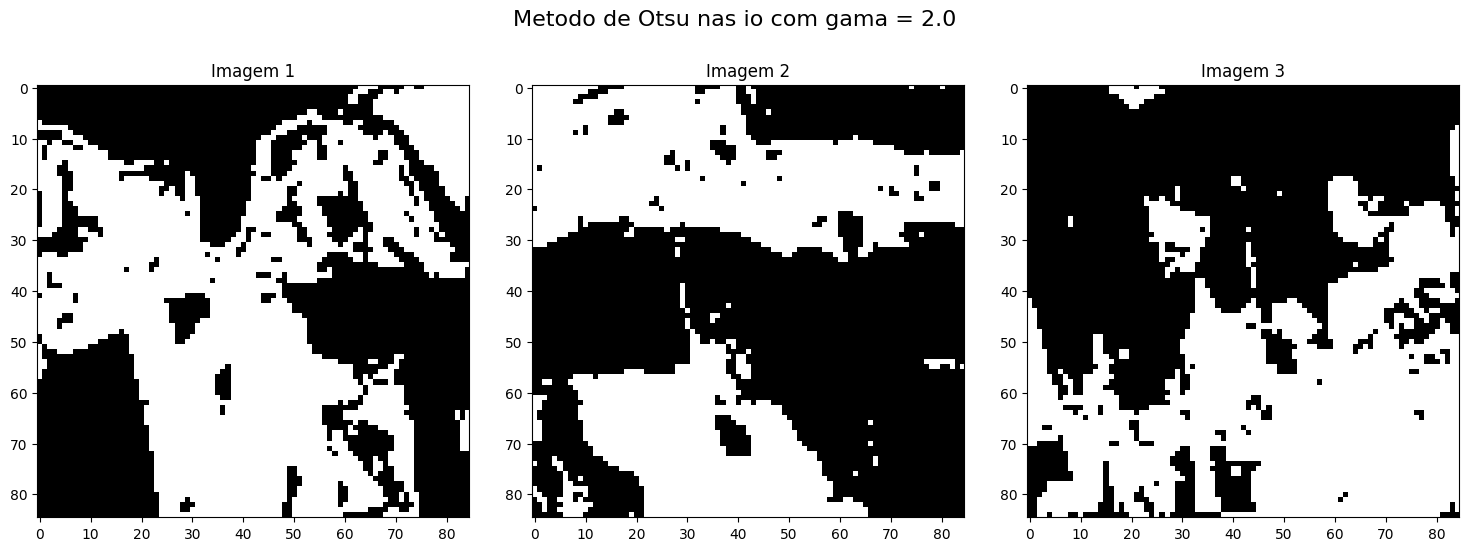

In [595]:
io_otsu0 = aplicar_otsu(imagens_cinza)
io_otsu1 = aplicar_otsu(io_gama1)
io_otsu2 = aplicar_otsu(io_gama2)

plot_imagens(io_otsu0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas imagens orginais")
plot_imagens(io_otsu1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas io com gama = 0.75")
plot_imagens(io_otsu2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas io com gama = 2.0")



##### Imagem Equalizada com Correção Gama

Aplicando Otsu: 100%|██████████| 3/3 [00:00<00:00, 704.85it/s]


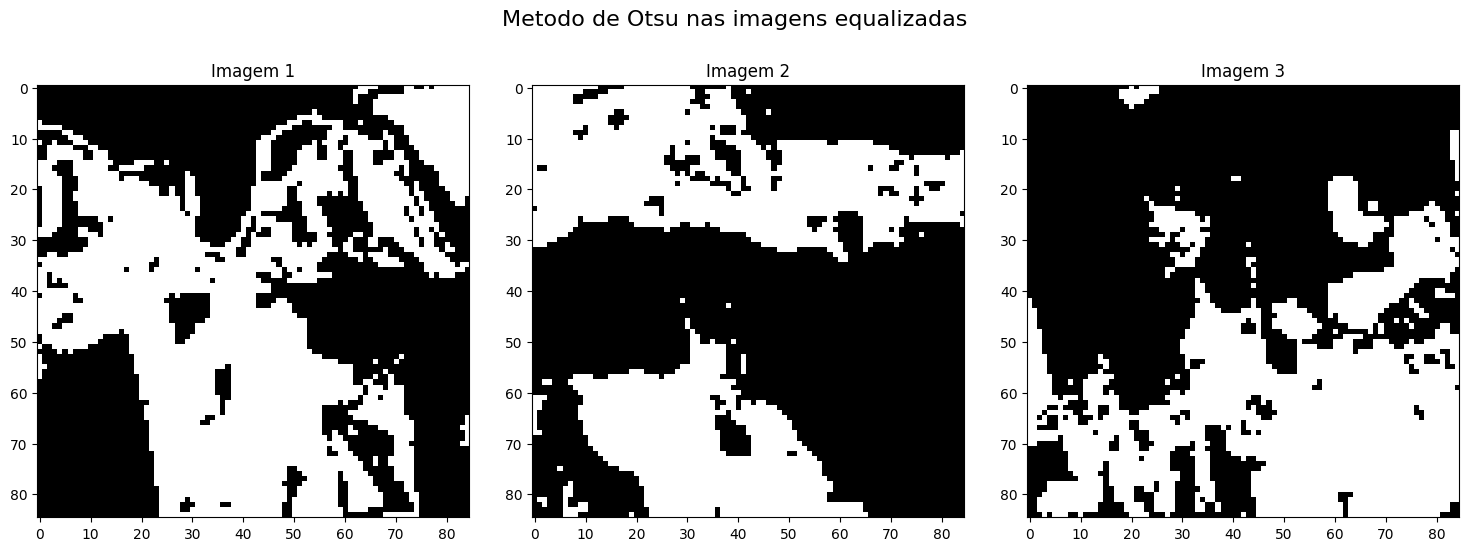

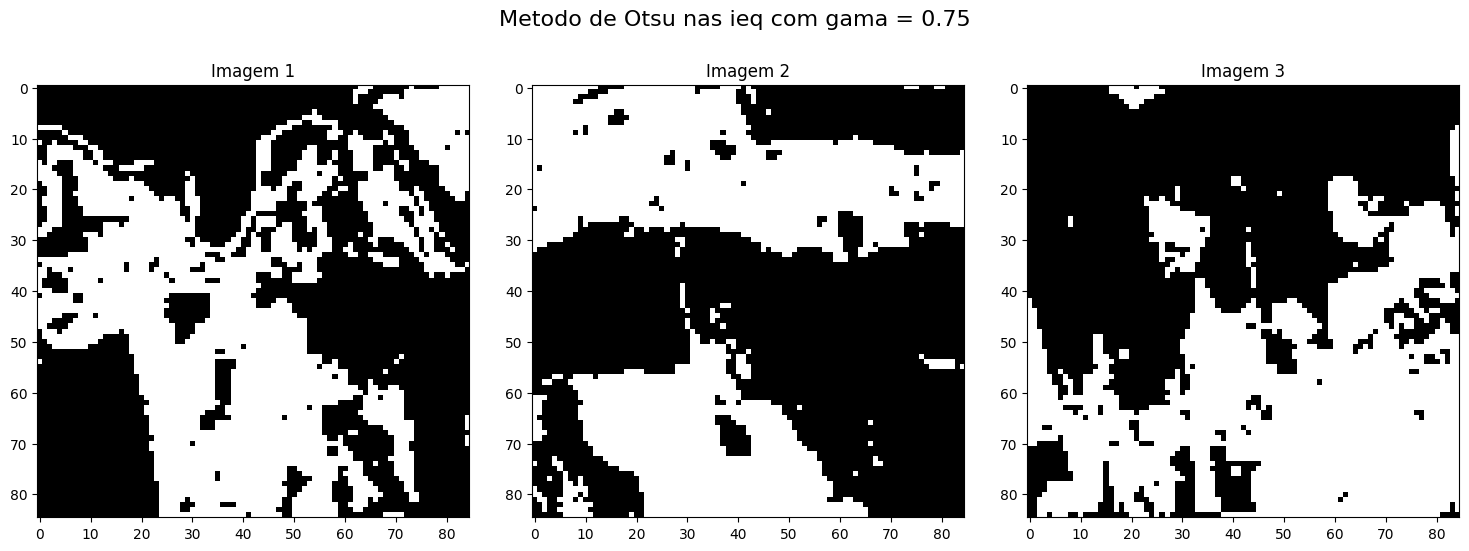

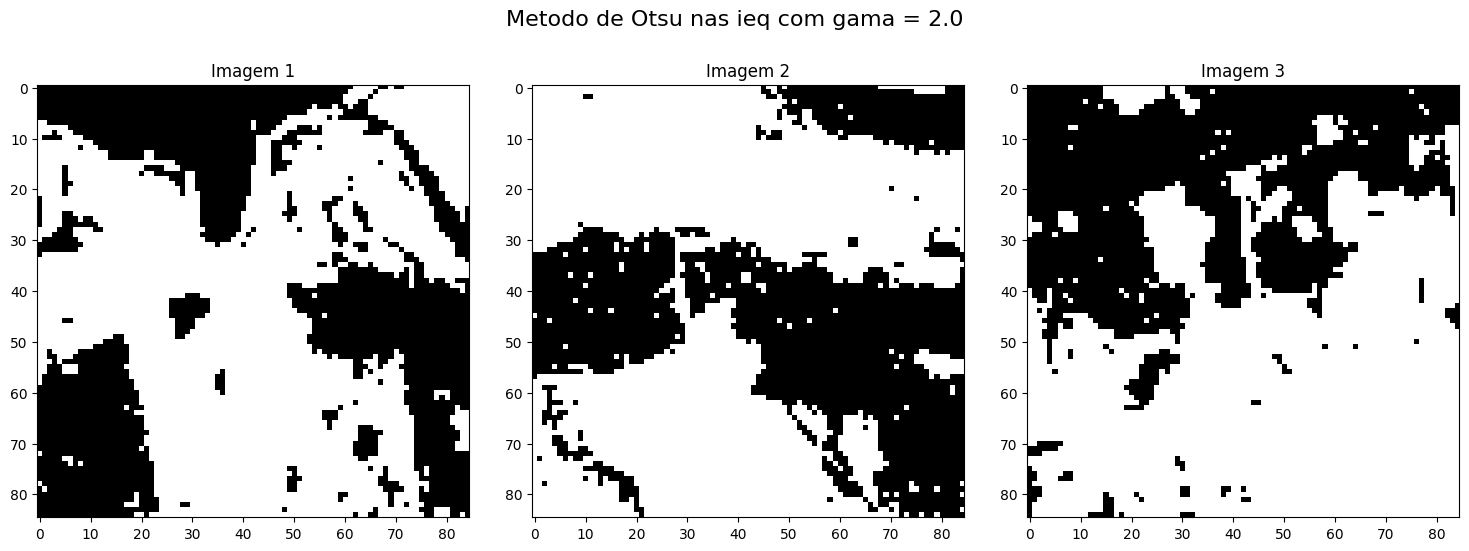

In [596]:
ieq_otsu0 = aplicar_otsu(imagens_cinza)
ieq_otsu1 = aplicar_otsu(ieq_gama1)
ieq_otsu2 = aplicar_otsu(ieq_gama2)

plot_imagens(ieq_otsu0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas imagens equalizadas")
plot_imagens(ieq_otsu1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas ieq com gama = 0.75")
plot_imagens(ieq_otsu2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas ieq com gama = 2.0")



Aplicando Otsu: 100%|██████████| 3/3 [00:00<00:00, 649.04it/s]


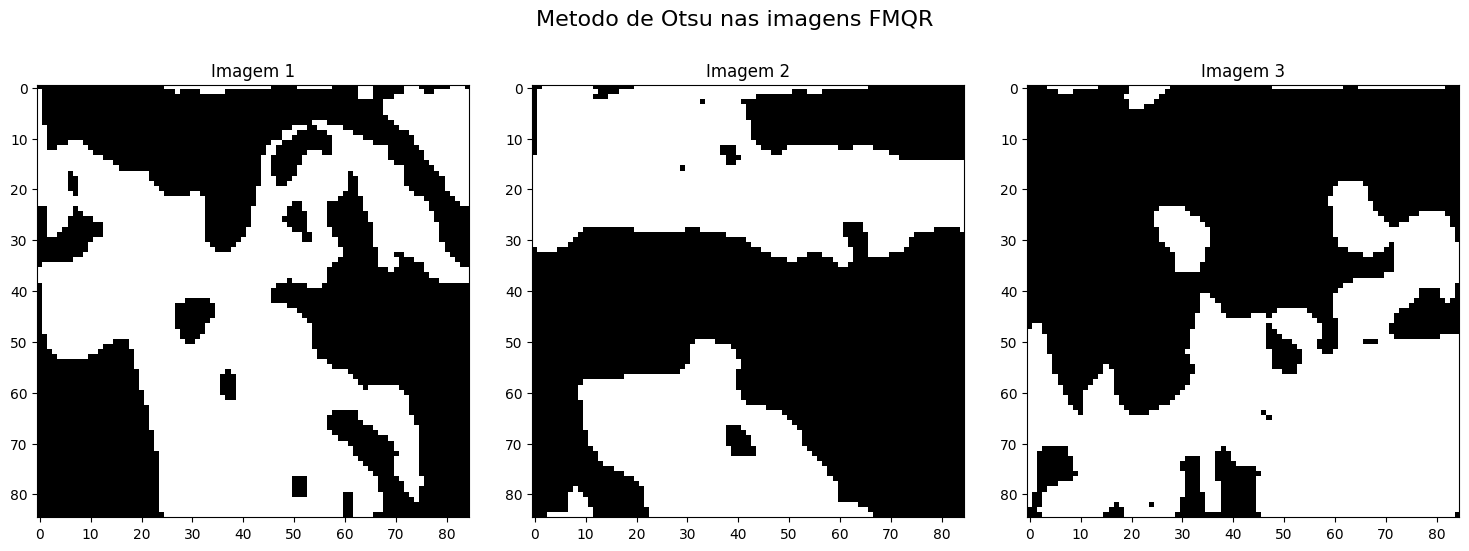

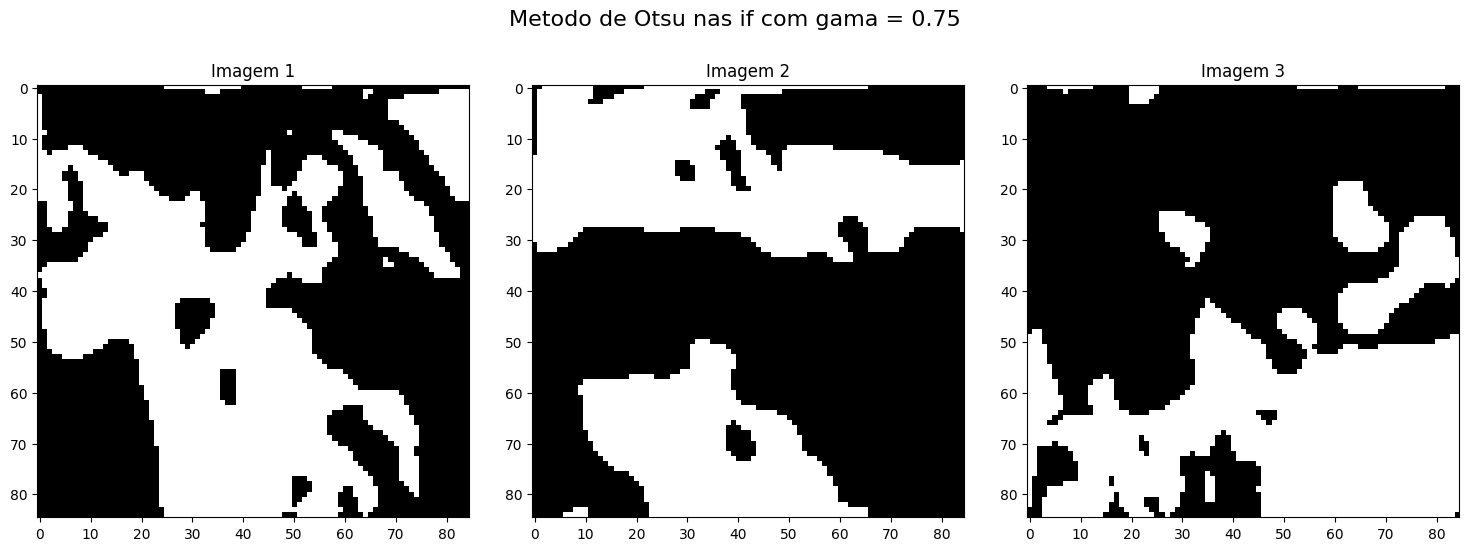

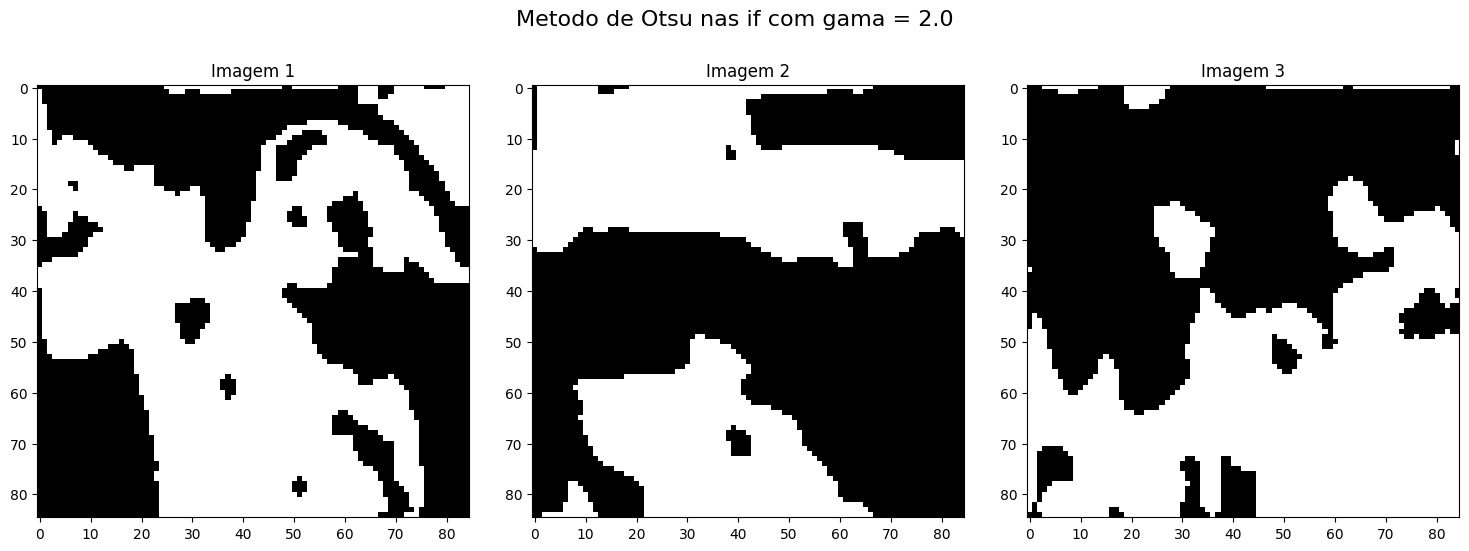

In [597]:
if_otsu0 = aplicar_otsu(imgs_fmqr)
if_otsu1 = aplicar_otsu(ifilt_gama1)
if_otsu2 = aplicar_otsu(ifilt_gama2)

plot_imagens(if_otsu0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas imagens FMQR")
plot_imagens(if_otsu1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas if com gama = 0.75")
plot_imagens(if_otsu2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Otsu nas if com gama = 2.0")



#### Segmentação com Metodo de Yen

Utilizando a biblioteca skimage

In [598]:
def aplicar_Yen(list_img):
    imagens_bin = []
    for img in tqdm(list_img, desc="Binarizando com Yen"):
        
        #calculo do limiar pelo skimage
        limiar = filters.threshold_yen(img)
        
        #cria a img binaria
        mascara_booleana = (img > limiar)
        
        #normaliza pra 0-255
        imagem_final = mascara_booleana.astype(np.uint8) * 255
        imagens_bin.append(imagem_final)
        
    
    return imagens_bin

Binarizando com Yen: 100%|██████████| 3/3 [00:00<00:00, 3713.96it/s]


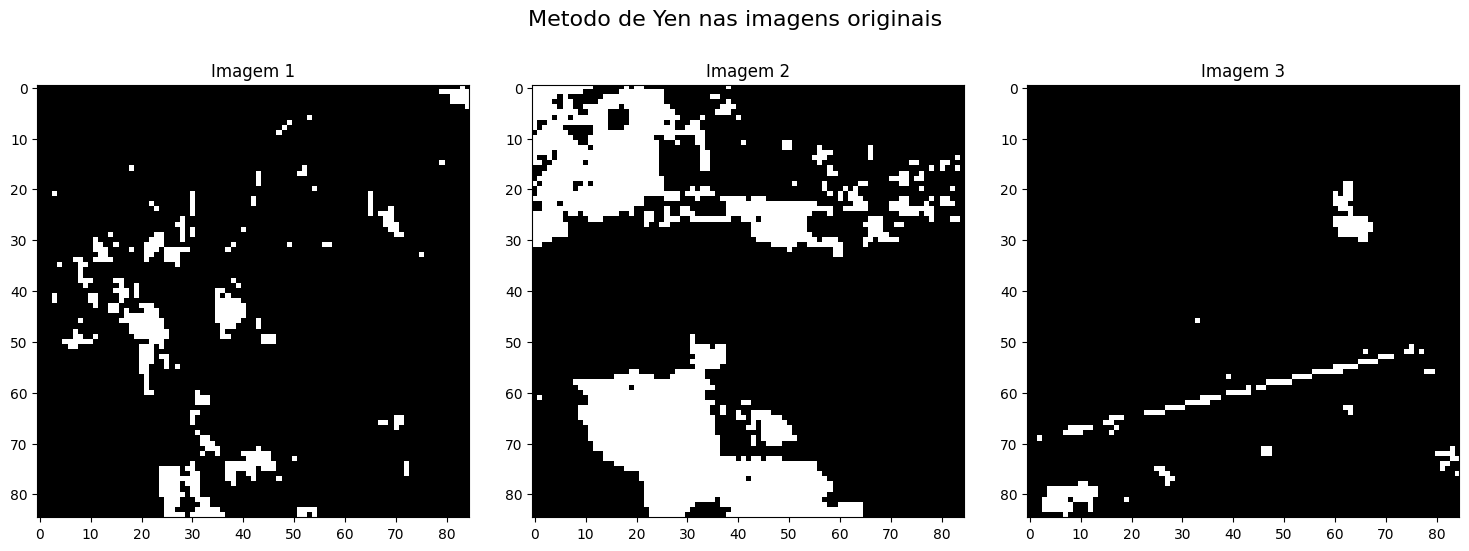

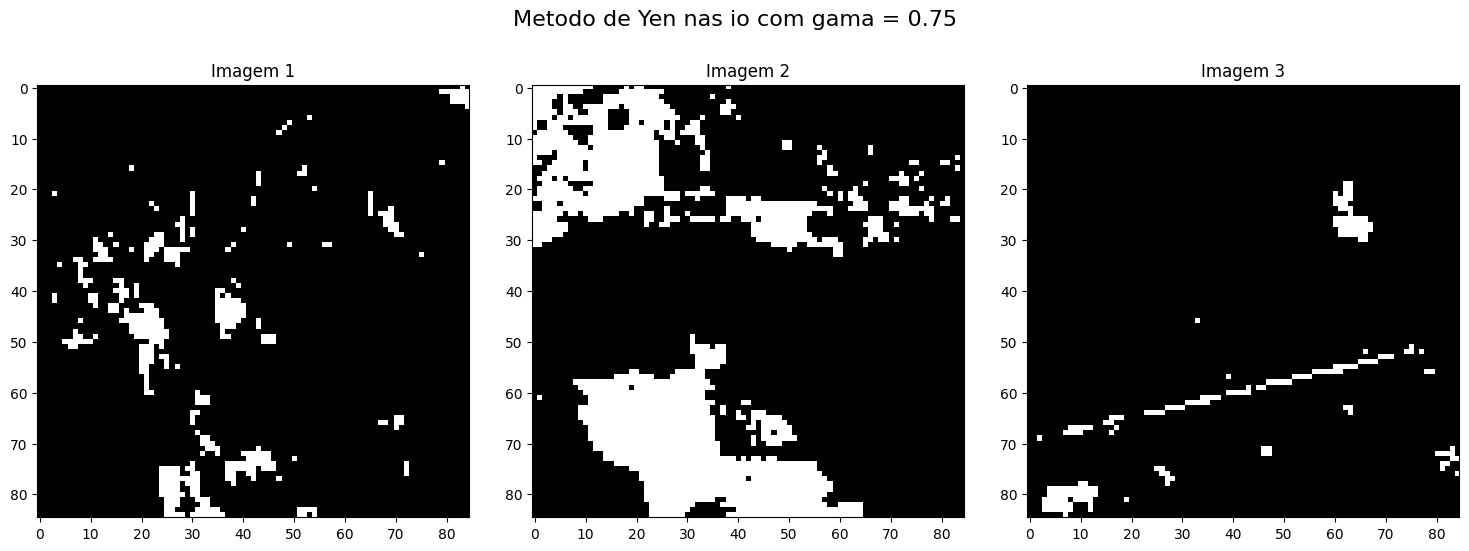

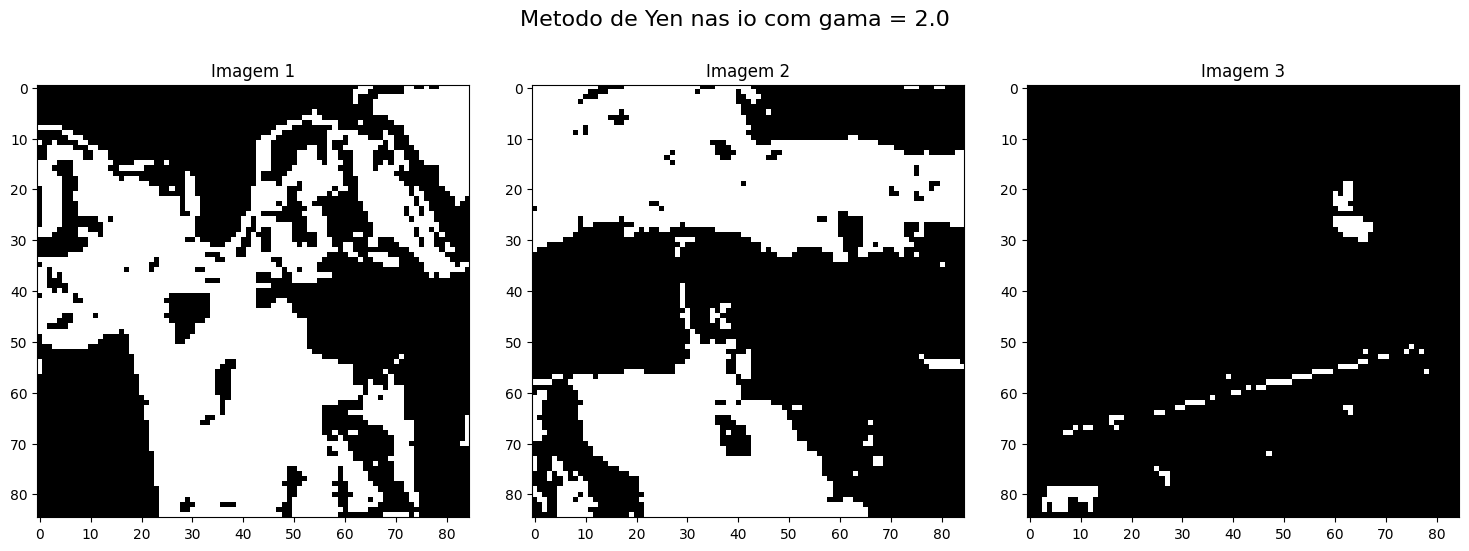

In [599]:
#Aplicando Yen em imagens filtrada com correções gama
io_Yen0 = aplicar_Yen(imagens_cinza)
io_Yen1 = aplicar_Yen(io_gama1)
io_Yen2 = aplicar_Yen(io_gama2)

plot_imagens(io_Yen0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas imagens originais")
plot_imagens(io_Yen1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas io com gama = 0.75")
plot_imagens(io_Yen2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas io com gama = 2.0")



Binarizando com Yen: 100%|██████████| 3/3 [00:00<00:00, 3045.97it/s]


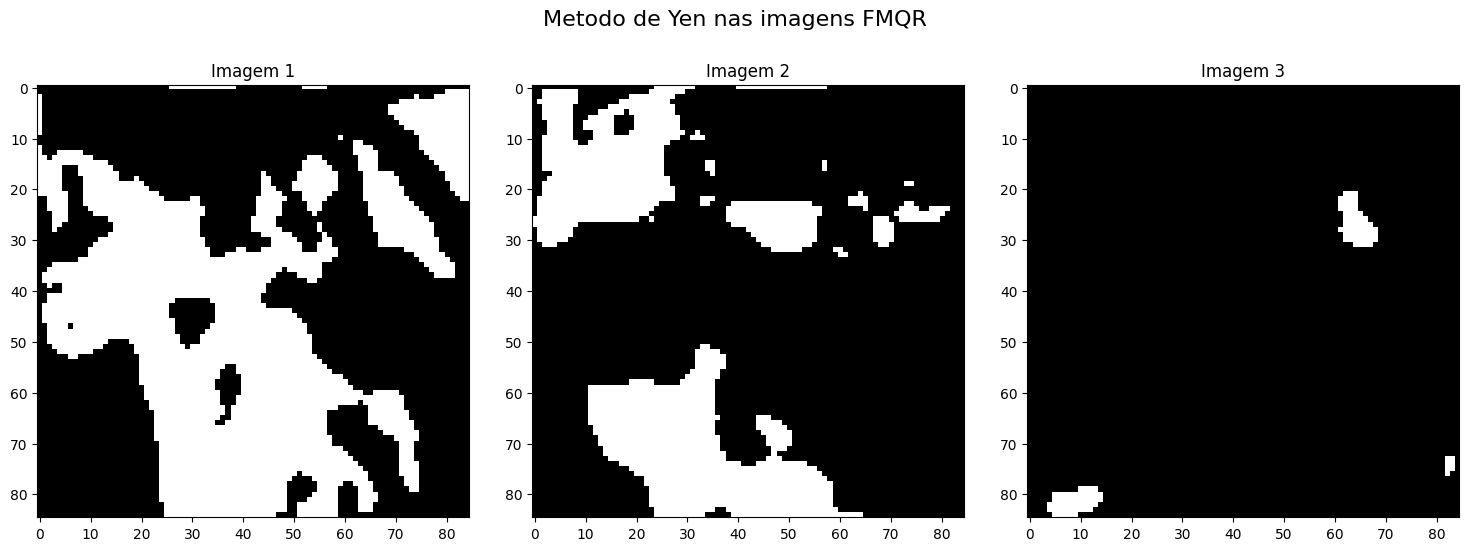

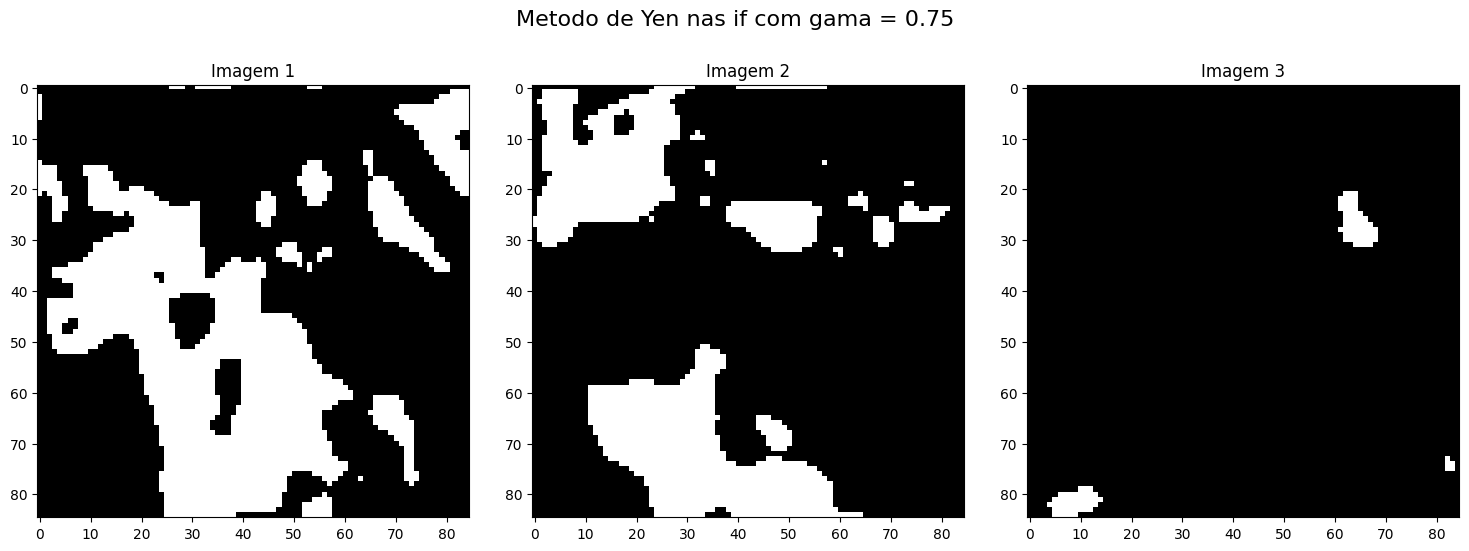

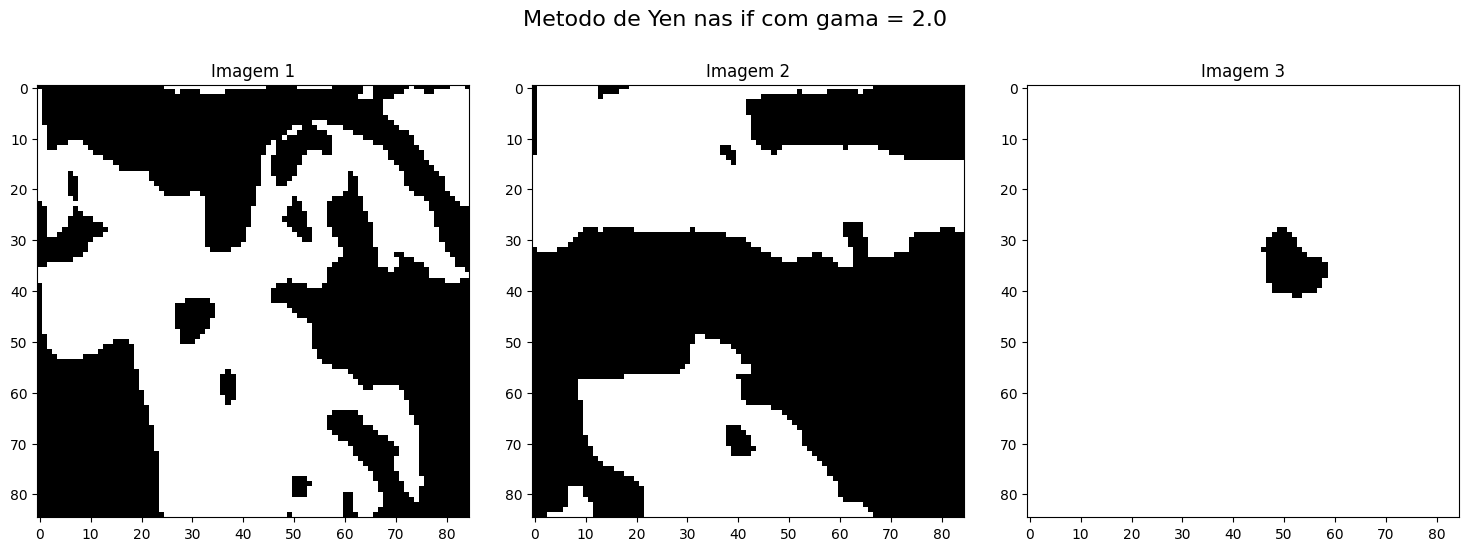

In [600]:
#Aplicando Yen em imagens filtrada com correções gama
if_Yen0 = aplicar_Yen(imgs_fmqr)
if_Yen1 = aplicar_Yen(ifilt_gama1)
if_Yen2 = aplicar_Yen(ifilt_gama2)

plot_imagens(if_Yen0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas imagens FMQR")
plot_imagens(if_Yen1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas if com gama = 0.75")
plot_imagens(if_Yen2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Metodo de Yen nas if com gama = 2.0")



#### Aplicando Morfologia Matematica

In [601]:
def open_close(img, selem):
    
    #realizando o processo de abertura ( erosão + dilatação)
    img_opened = morphology.binary_opening(img,selem)

    #realizando o processo de fechamentro (dilatação + erosão)
    img_result = morphology.closing(img_opened, selem)

    #retorna uma nova img
    return img_result

def aplicar_Morph(list_img, selem):
    # Recebe uma lista de imagens e retorna uma outra lista com imagens 
    imgs_morph = []
    # Usando tqdm para visualizar o progresso
    for img in tqdm(list_img, desc="Aplicando Morfologia Matemática (Abertura e  Fechamento)"):
        morph = open_close(img, selem)
        imgs_morph.append(morph)
    return imgs_morph

/tmp/ipykernel_17231/3780236525.py:1: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morphology.square(4)
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 109.09it/s]
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 119.17it/s]
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 316.61it/s]


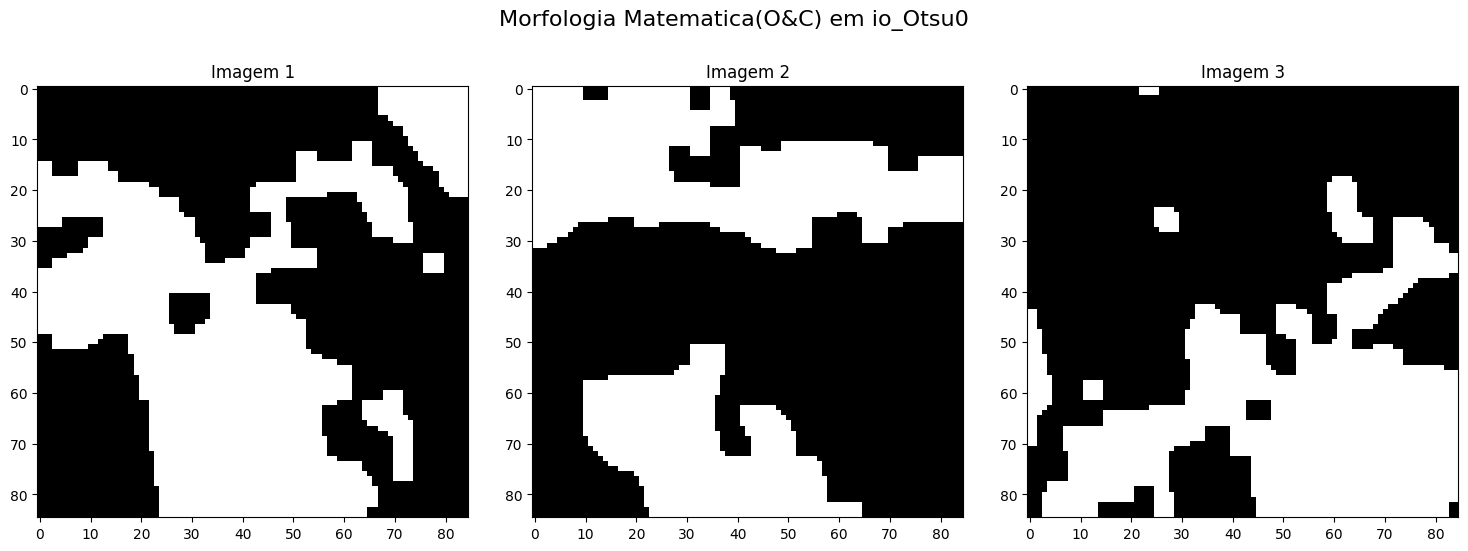

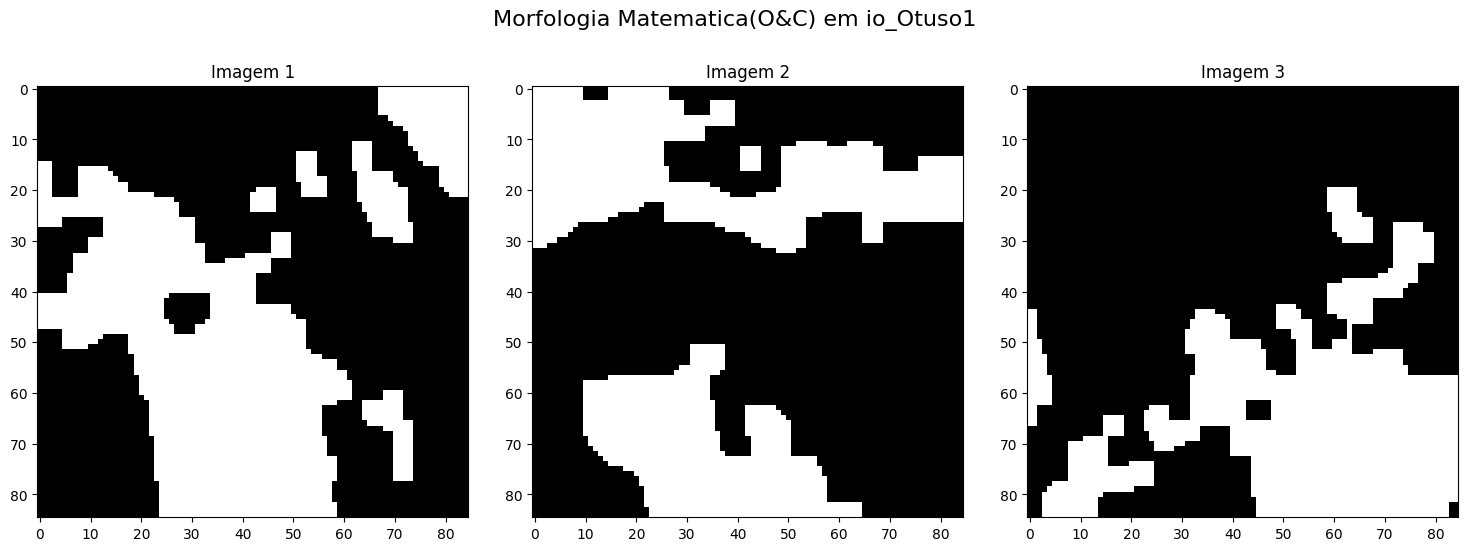

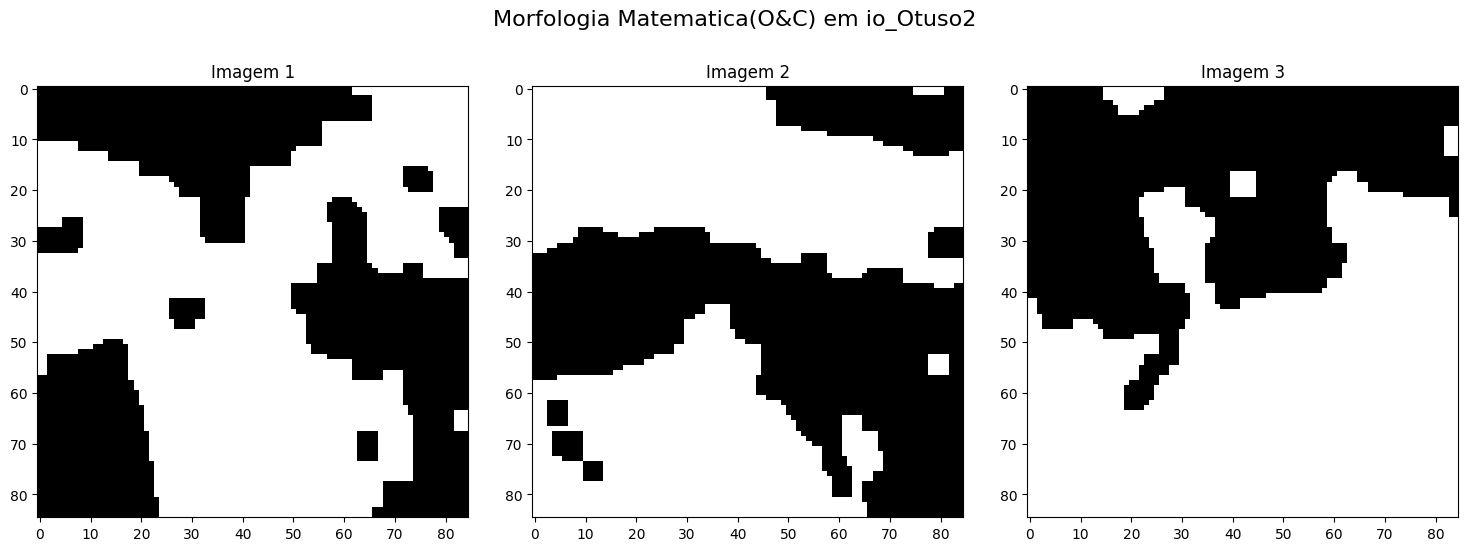

In [602]:
selem = morphology.square(4)
io_m0 = aplicar_Morph(io_otsu0,selem)
io_m1 = aplicar_Morph(io_otsu1,selem)
io_m2 = aplicar_Morph(ieq_otsu2,selem)

plot_imagens(io_m0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em io_Otsu0")
plot_imagens(io_m1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em io_Otuso1")
plot_imagens(io_m2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em io_Otuso2")



/tmp/ipykernel_17231/1430966800.py:1: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morphology.square(4)
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 356.54it/s]
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 406.53it/s]
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 367.93it/s]


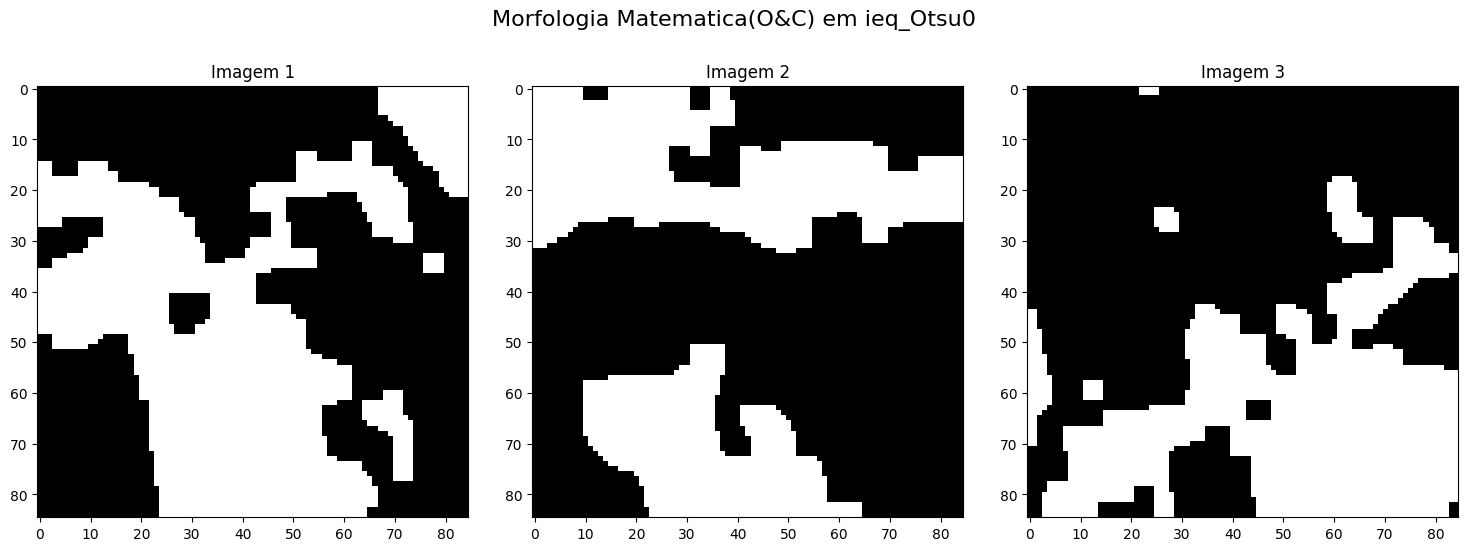

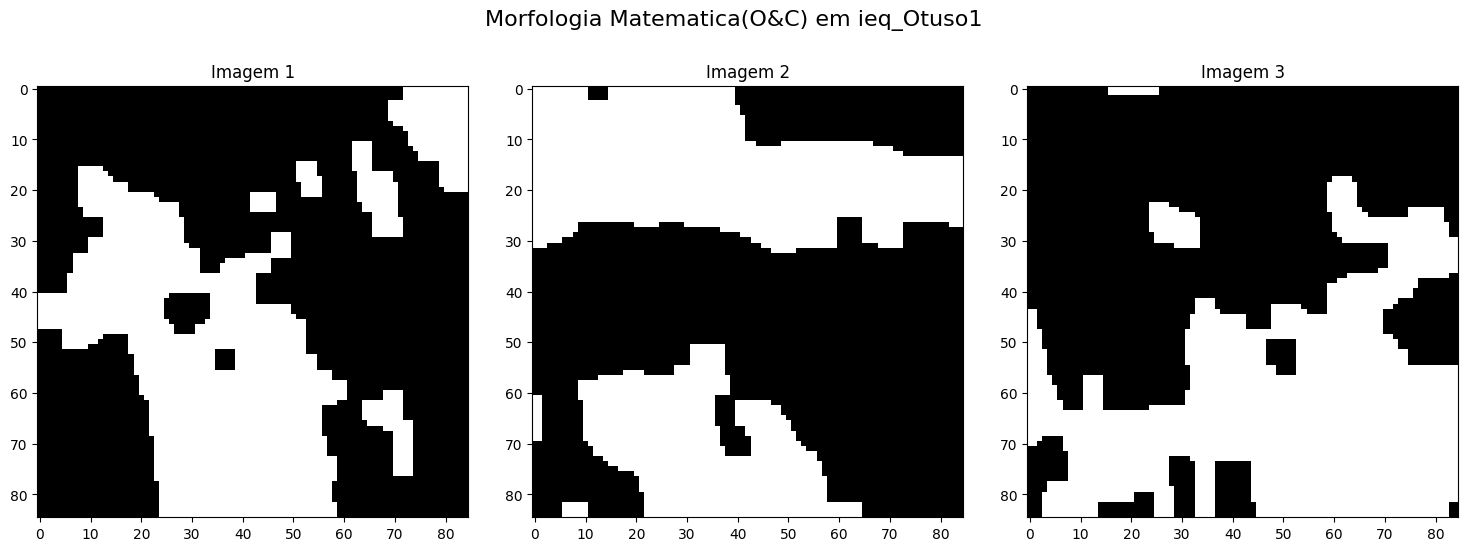

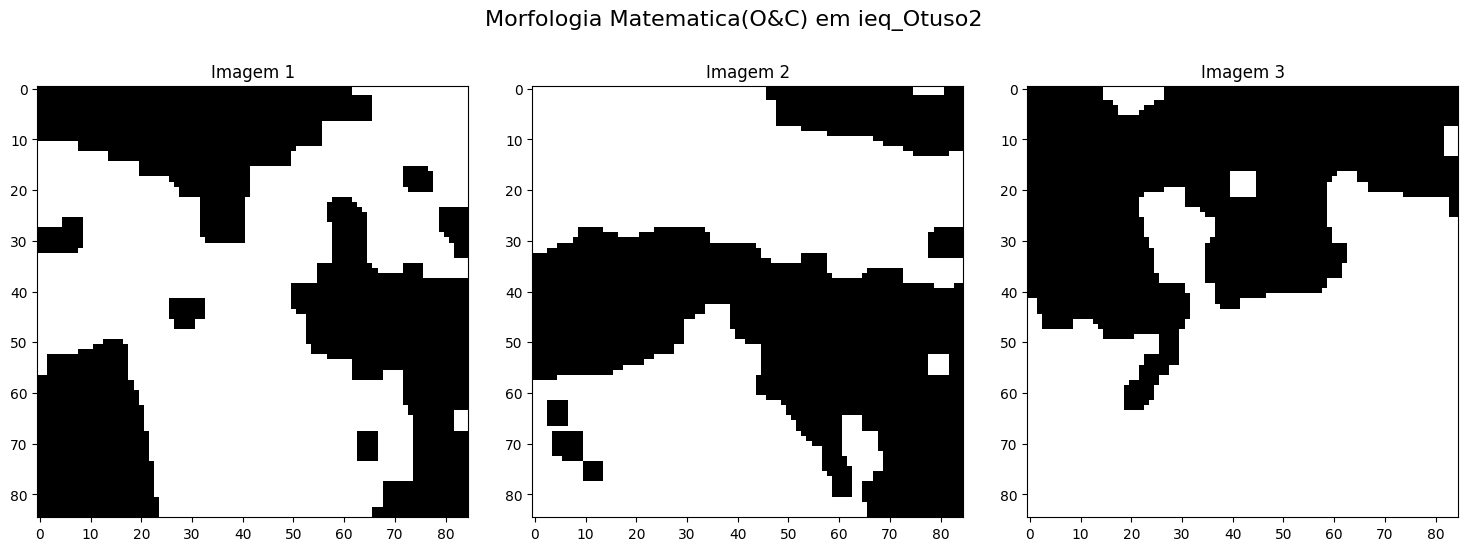

In [603]:
selem = morphology.square(4)
ieq_m0 = aplicar_Morph(ieq_otsu0,selem)
ieq_m1 = aplicar_Morph(ieq_otsu1,selem)
ieq_m2 = aplicar_Morph(ieq_otsu2,selem)

plot_imagens(ieq_m0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em ieq_Otsu0")
plot_imagens(ieq_m1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em ieq_Otuso1")
plot_imagens(ieq_m2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em ieq_Otuso2")


/tmp/ipykernel_17231/1830637381.py:1: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morphology.square(4)
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 433.58it/s]
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 307.07it/s]
Aplicando Morfologia Matemática (Abertura e  Fechamento): 100%|██████████| 3/3 [00:00<00:00, 327.47it/s]


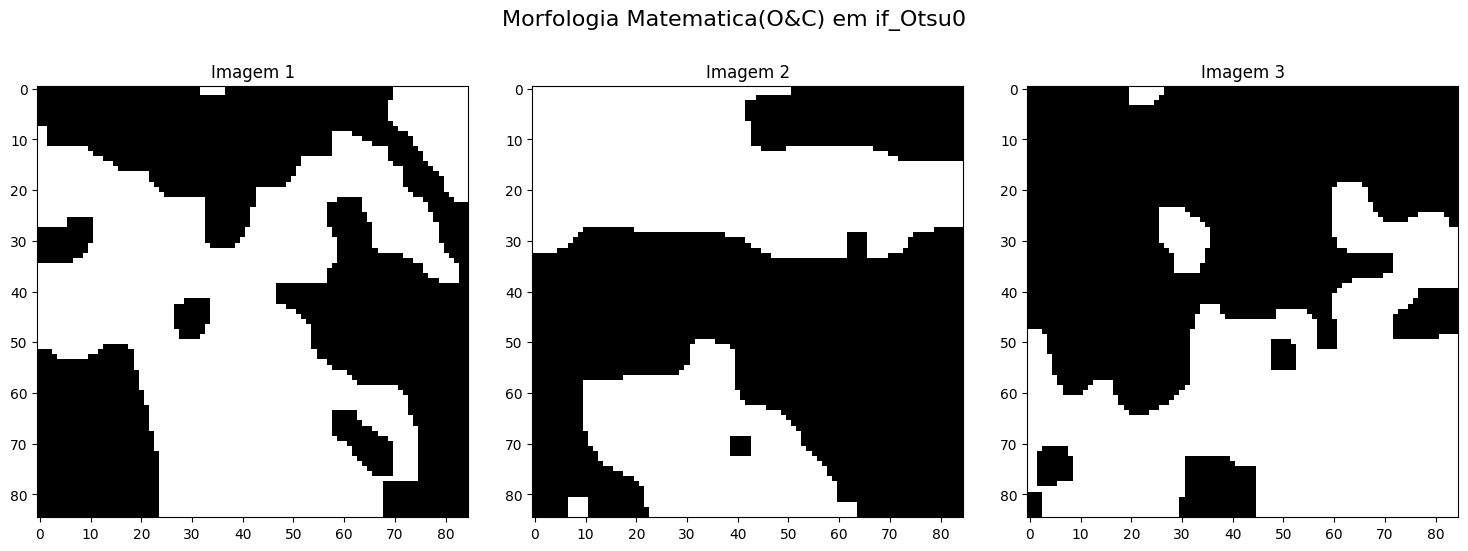

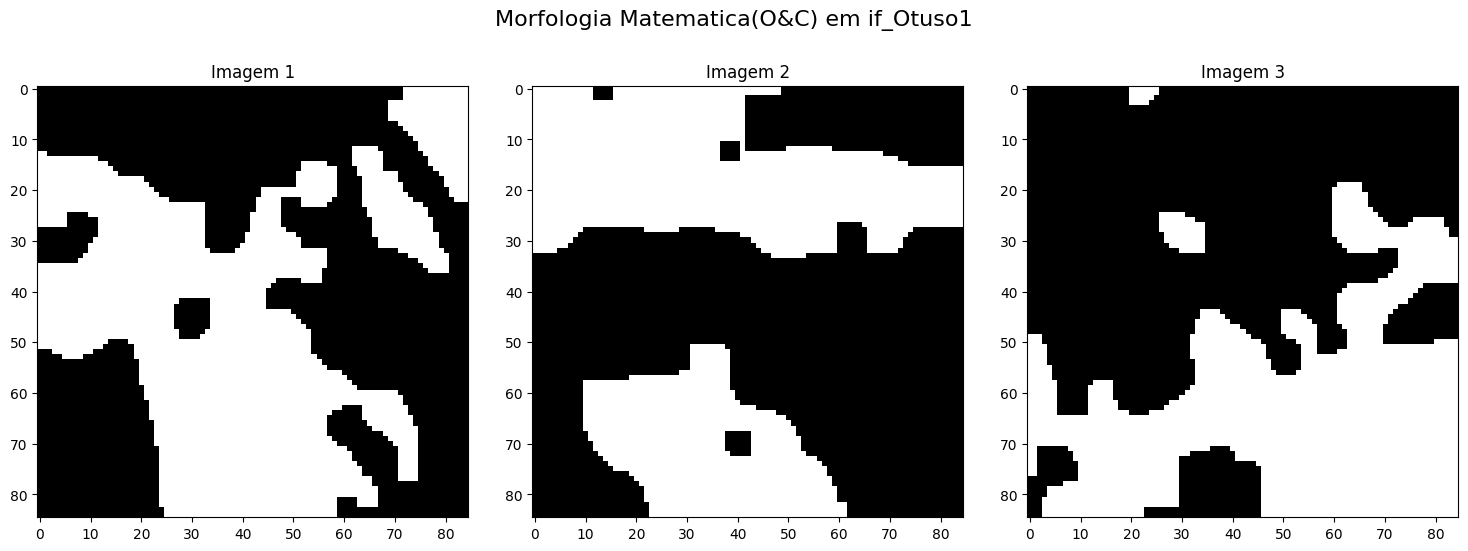

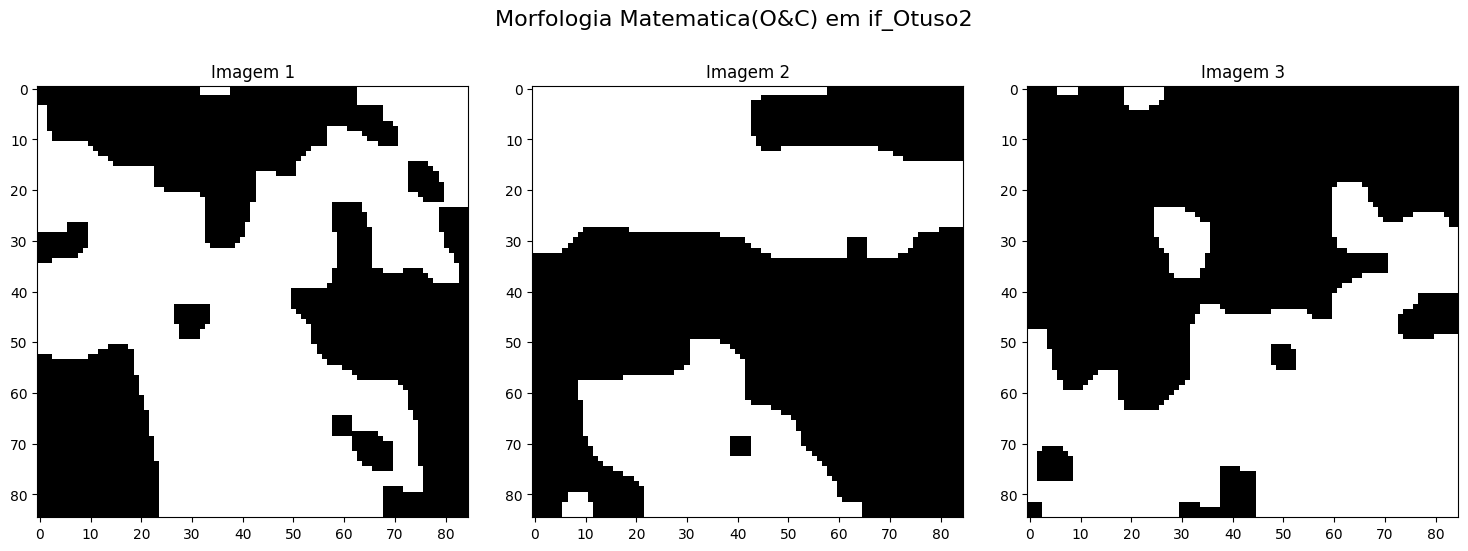

In [604]:
selem = morphology.square(4)
if_m0 = aplicar_Morph(if_otsu0,selem)
if_m1 = aplicar_Morph(if_otsu1,selem)
if_m2 = aplicar_Morph(if_otsu2,selem)

plot_imagens(if_m0, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em if_Otsu0")
plot_imagens(if_m1, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em if_Otuso1")
plot_imagens(if_m2, ['Imagem 1', 'Imagem 2','Imagem 3'], f"Morfologia Matematica(O&C) em if_Otuso2")


### Closing the Datasets
The ImageSegmentationDataset class holds open file handles to NetCDF files which need to be manually closed.

In [605]:
dataset.close()

### Incorporation into Training and Evaluation
This dataset can be wrapped in a straightforward manner for use in a desired ML training / evaluation framework, allowing for selection of desired data from within the returned dictionary, applying data transforms such as image resizing, and converting to framework compatible types.